<a href="https://colab.research.google.com/github/SLKS99/Understanding-the-Ligand-Assisted-Reprecipitation-of-CsPbBr3-Perovskite-Nanocrystals-via-High-Throug/blob/main/OAc_OLam_CSPbBr3_Chloroform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

January 5, 2023


Contributions:
- Data by Mahshid Ahmadi and Sheryl Sanchez, Jonghee Yang
- Analysis by Sheryl Sanchez and Jonghee Yang


In [1]:
#@title Import Modules 

import numpy as np
import pandas as pd


#Plotting Tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

import seaborn as sns

#gdown Installation
!pip install gdown==3.6.0

!pip install lmfit

from lmfit.models import GaussianModel, ExponentialModel, ConstantModel
import lmfit

from lmfit import Model
from lmfit import minimize


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for gdown: filename=gdown-3.6.0-py3-none-any.whl size=5236 sha256=3148e8758098c982ca58d61f9c0b13c52eae9d3dd95012e11e81f8051cf7b9c6
  Stored in directory: /root/.cache/pip/wheels/7f/54/b8/4e7b8c9e72e87fa54971ca6230962fdff21aa76113081c4c59
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 KB 9.8 MB/s eta 0:00:00


## User Input

In [2]:
#@title Experimental Data 

#Names of Precursors
precursor1 = '$CsPbBr3_3$' #@param {type:"string"}


#Wells that we should ignore
wells_to_ignore = 'A11,B11,C11,D11,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12,A12,B12,C12,D12' #@param {type:"string"}

#Information about Measurement Range
start_wavelength = 400 #@param {type:"integer"}
end_wavelength =  650 #@param {type:"integer"}
wavelength_step_size =  2 #@param {type:"integer"}

time_step = 7 #@param {type:"integer"}

#Information about the reads
number_of_reads =   103#@param {type:"integer"}
luminescence_read_numbers = '3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79,81,83,85,87,89,91,93,95,97,99,101' #@param {type:"string"}

#Convert the string into a list to use later 
if len(wells_to_ignore) != 0:
  wells_to_ignore = list(wells_to_ignore.split(","))
luminescence_read_numbers = list(luminescence_read_numbers.split(","))

In [3]:
#@title Data Information

#Name of files 
data_file_name = '6-16-22 CsPbBr3 PNC220617_CsPbBr3 QD ligands ratio readings chloroform.csv' #@param {type:'string'}
composition_file_name = 'CsPbBr3 wells.csv' #@param {type:'string'}

#Download the correct data
data_file = '1LiNBcSiHNPPNK8ikGTmfssTdR0VMH2L_' #@param {type:"string"}
composition_file = '1z-s5yzD9nsAB9QVAyUcleWxB_RCQvUkt' #@param {type:"string"}

## Downloading and Formating Data

In [4]:
#@title Download Files

!gdown https://drive.google.com/uc?id={data_file}

!gdown https://drive.google.com/uc?id={composition_file}

Downloading...
From: https://drive.google.com/uc?id=1LiNBcSiHNPPNK8ikGTmfssTdR0VMH2L_
To: /content/6-16-22 CsPbBr3 PNC220617_CsPbBr3 QD ligands ratio readings chloroform.csv
100% 3.08M/3.08M [00:00<00:00, 124MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z-s5yzD9nsAB9QVAyUcleWxB_RCQvUkt
To: /content/CsPbBr3 wells.csv
100% 3.15k/3.15k [00:00<00:00, 3.20MB/s]


In [5]:
#@title Into Pandas Dataframes
rawData = pd.read_csv(data_file_name,header=None)
rawData = rawData.replace('OVRFLW', np.NaN)
rawData = rawData.replace(r'^\s*$', np.NaN, regex=True)
composition = pd.read_csv(composition_file_name, index_col = 0)



In [6]:
#@title Parsing the Data into a Dictionary
cells = [] 

for i in range(1, 9):
  for j in range(1 , 13): 
    cells.append(chr(64 + i) + str(j))

for i in wells_to_ignore:
  cells.remove(i)

for i in wells_to_ignore: 
  composition = composition.drop(i, axis = 1)
if not luminescence_read_numbers:
  for i in luminescence_read_numbers:
    cells= cells.remove(i)
# This is to drop the compostions I want removed
#First the rows of measurements 
rows = []

for i in range(1, number_of_reads + 1): 
  rows += rawData[rawData[rawData.columns[0]] == 'Read ' + str(i) + ':Spectrum'].index.tolist()
  rows += rawData[rawData[rawData.columns[0]] == 'Read ' + str(i) + ':EM Spectrum'].index.tolist()

rows += rawData[rawData[rawData.columns[0]] == 'Results'].index.tolist()

#Separate into different dataframes 

#First step, make a list of the names 
names = []

for i in range(1, number_of_reads + 1):
  names.append('Read ' + str(i))

#Next, make a dictionary 
d = {}

for c in names:
  split_name = c.split(' ')
  index = int(split_name[1])
  d[c] = rawData[rows[index - 1] + 2 :rows[index] - 1] #Take a section of the values 
  d[c] = d[c].drop([0], axis = 1) #Drop the empty column
  new_header = d[c].iloc[0] #grab the first row for the header
  d[c] = d[c][1:] #take the data less the header row
  d[c].columns = new_header #set the header row as the df header
  for i in wells_to_ignore: 
    d[c] = d[c].drop(i, axis = 1)
  d[c] = d[c].astype(float) #Make sure that it is composed of numbers
  

In [7]:
#@title Convert the Dictionary into an Array
#Convert  into an array
luminescence_time = np.array(luminescence_read_numbers)
luminescence_time = [int(i) * time_step for i in luminescence_time]

#Convert wavelength information into an array
luminescence_wavelength = np.arange(start_wavelength,end_wavelength + wavelength_step_size,wavelength_step_size)

#Make a grid
nx, ny = np.meshgrid(luminescence_wavelength, luminescence_time)

#Load information into a dataframe
luminescence_df = pd.DataFrame()

for i in luminescence_read_numbers:
  
  luminescence_df  = luminescence_df.append(d['Read ' +str(i)])

luminescence_df.insert(loc = 0, column = 'Time', value = ny.ravel())

luminescence_df = luminescence_df.fillna(0.0)

luminescence_vec = np.array(luminescence_df)


Text(0, 0.5, 'Intensity (a.u.)')

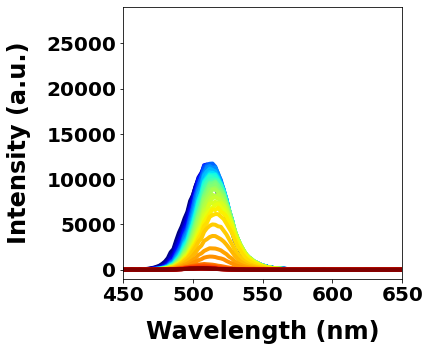

In [8]:
#@title Single Well
plt.rcParams['font.sans-serif'] = 'Calibri'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.size"] = "20"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.rcParams['axes.titleweight']='bold'



well = 'A4' #@param {type:"string"}

#Define the figure
fig1 = plt.figure(figsize=(5,5))
ax1 = fig1.add_subplot(111)

colors = cm.jet(np.linspace(0, 1, len(luminescence_read_numbers)))

color_holder = 0

for i in luminescence_read_numbers:
 
  plot_row = 0
  plot_column = 0
      
  d['Read ' + str(i)].plot(x = 'Wavelength', y = well, ax = ax1, legend = False, linewidth=4, c = colors[color_holder])
  color_holder += 1
plt.xlim(450,650)
plt.ylim(-1000,29000)
#plt.title('1:2 OAc:OLAm')
plt.xlabel('Wavelength (nm)', labelpad=15,size=24)
plt.ylabel('Intensity (a.u.)', labelpad=15,size=24)

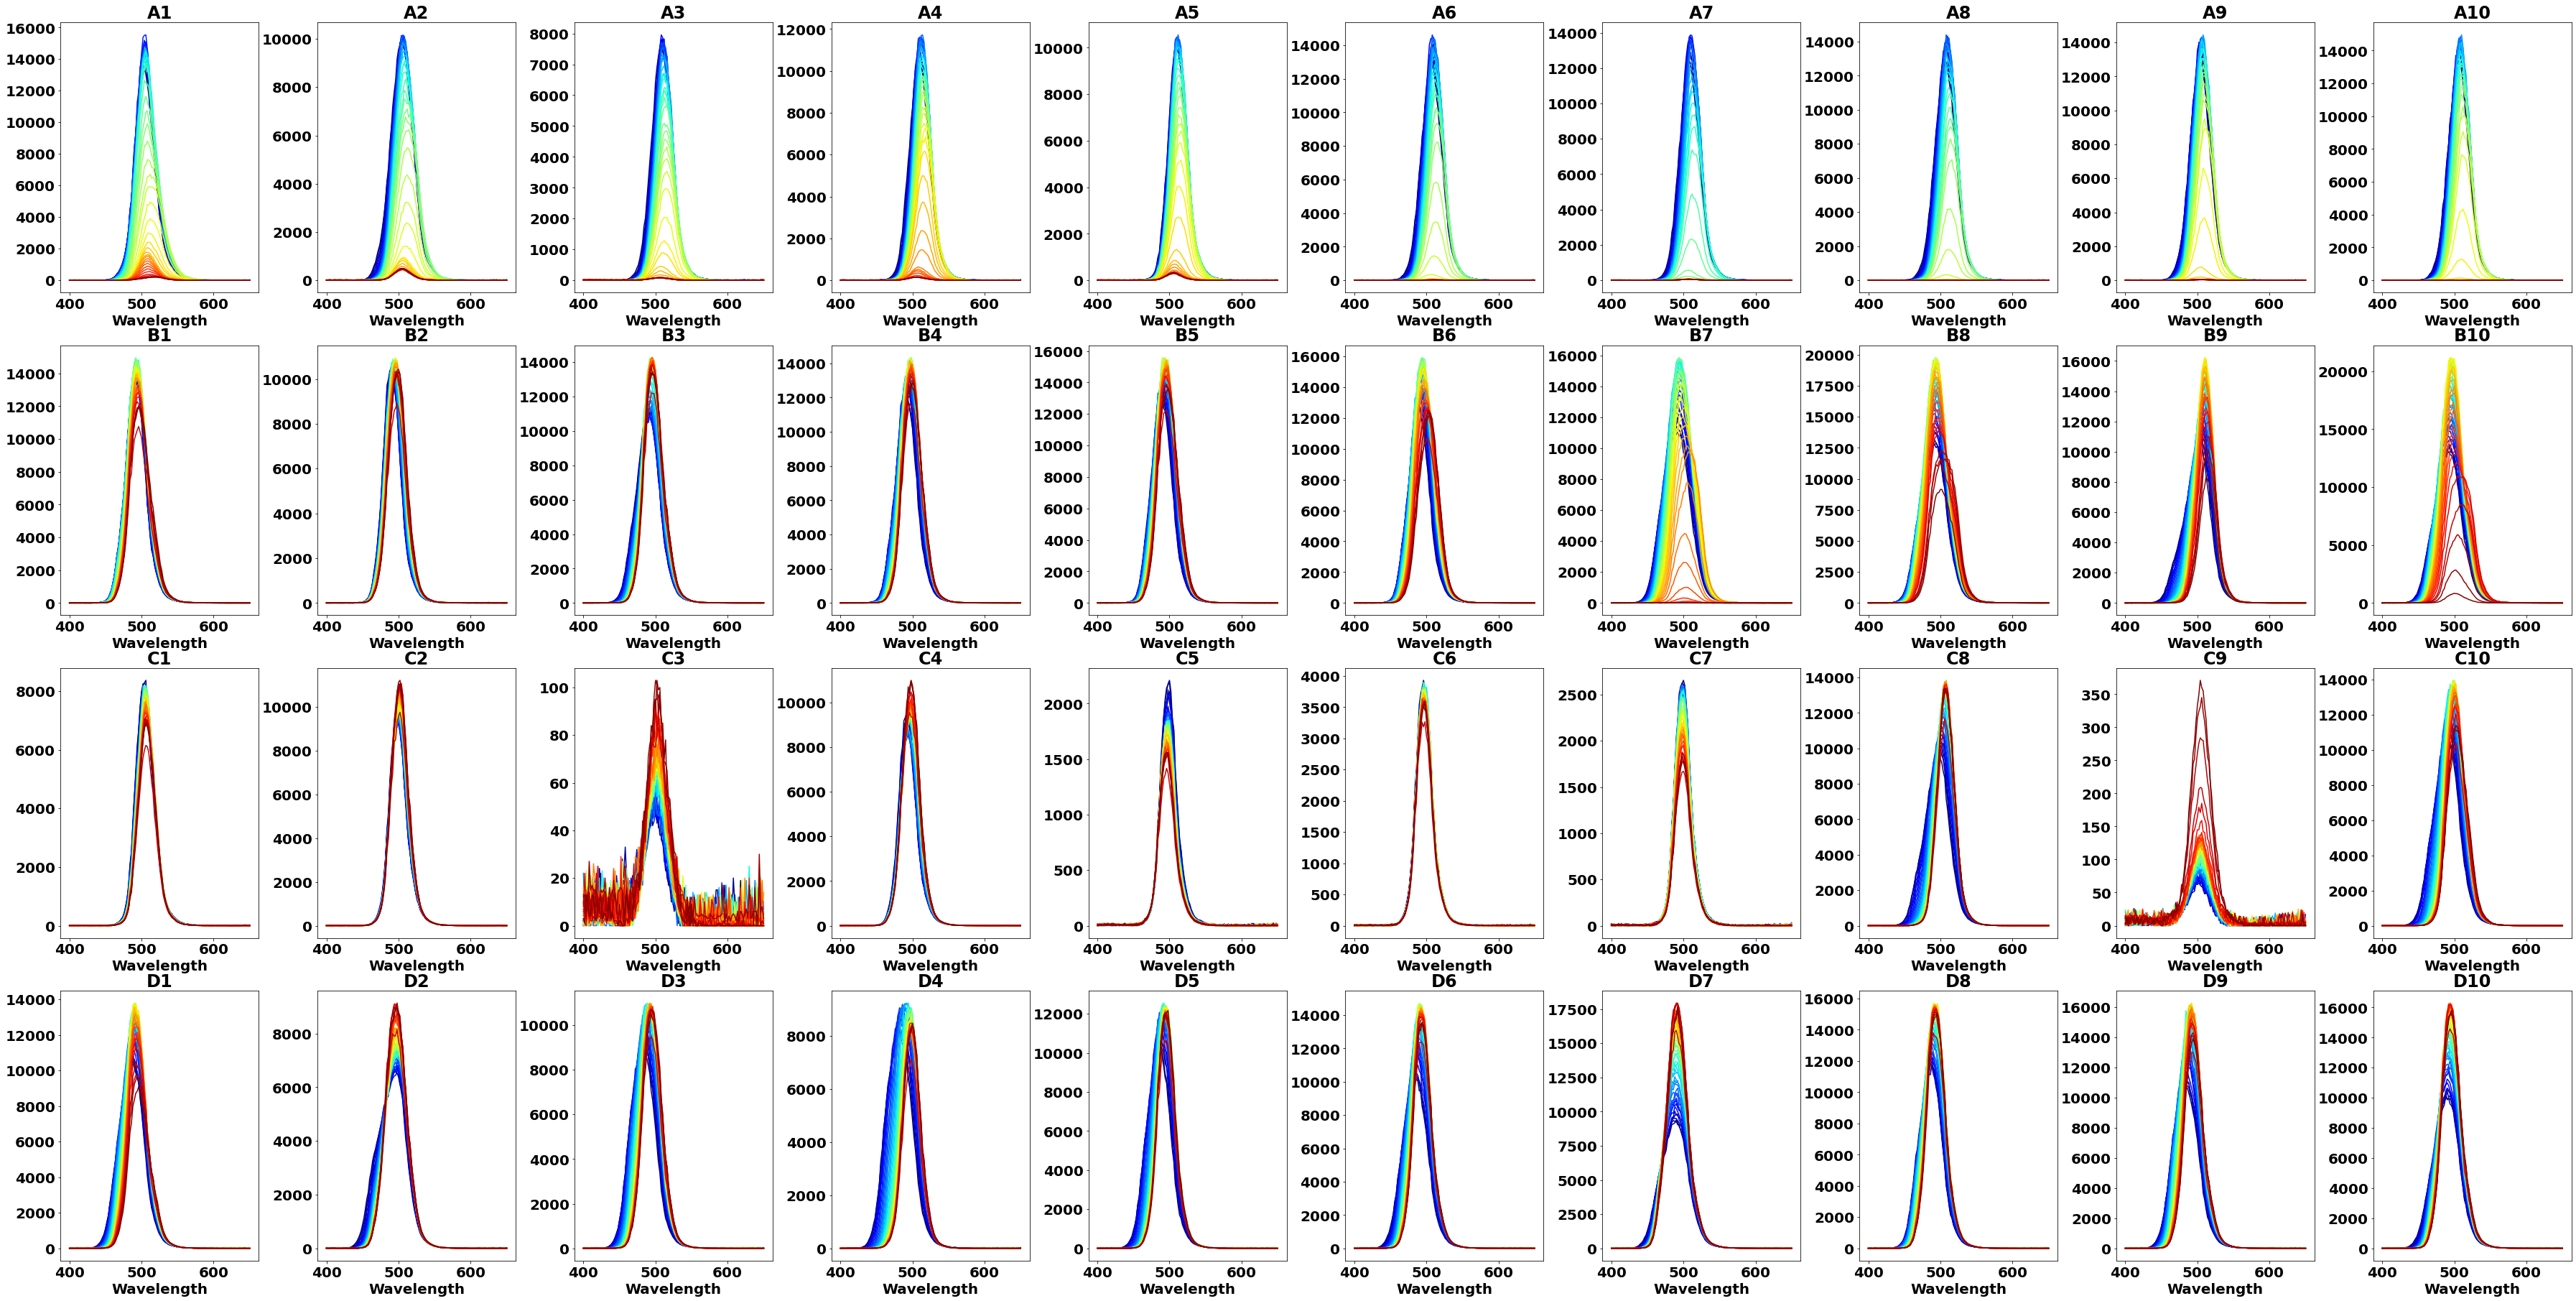

In [10]:
#@title Time Evolution for Luminescence
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = ['Calibri'] + plt.rcParams['font.sans-serif']
plt.rcParams["font.size"] = "20"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.rcParams['axes.titleweight']='bold'

num_of_rows = 4
num_of_cols = 10

#Define the figure
fig, axes = plt.subplots(nrows = num_of_rows , ncols = num_of_cols, figsize = (50,25))
fig.tight_layout(h_pad=2)

colors = cm.jet(np.linspace(0, 1, len(luminescence_read_numbers)))

for i in range(len(luminescence_read_numbers)): 
  
  plot_row = 0
  plot_column = 0

  for j in range(len(cells)): 
    if cells[j] not in wells_to_ignore:
      d['Read '+ str(luminescence_read_numbers[i])].plot(x = 'Wavelength', y = cells[j], ax = axes[plot_row, plot_column], title = str(cells[j]), legend = False, c = colors[i])
    

    #Putting the plots where they need to be 
    plot_column += 1
    if plot_column == 10:
      plot_row += 1
      plot_column = 0
plt.savefig('OAc OLAm Time evolution plot.tif', bbox_inches='tight',dpi=300)

In [11]:
luminescence_vec.shape

(6300, 42)

In [13]:
6300/126

50.0

In [12]:
luminescence_wavelength.shape

(126,)

In [14]:
ldata = luminescence_vec.reshape([50,126,42])
print(ldata.shape, luminescence_wavelength.shape)
print(luminescence_wavelength.max())

(50, 126, 42) (126,)
650


Text(24.0, 0.5, 'Time (min)')

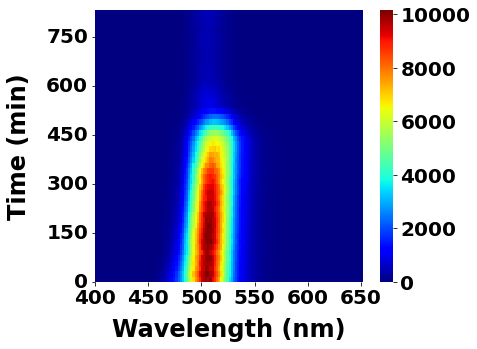

In [15]:

plt.rcParams['font.sans-serif'] = 'Calibri'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 20
plt.figure(figsize=(6,5))
ax2=sns.heatmap(ldata[:,:,3], cmap='jet')
ax2.invert_yaxis()
ax2.set_yticks([0,9,18,27,36,45])
ax2.set_yticklabels([0,150,300,450,600,750])
ax2.set_xticks(np.arange(0,len(luminescence_wavelength),25))
ax2.set_xticklabels(luminescence_wavelength[0::25], rotation='horizontal')
ax2.set_xlabel('Wavelength (nm)', labelpad=10, size=24)
ax2.set_ylabel('Time (min)', labelpad=15, size=24)

In [ ]:
d['Read 3'].drop(['Wavelength'],axis=1)

1220,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10
1221,4.0,0.0,17.0,0.0,7.0,9.0,0.0,0.0,0.0,0.0,...,6.0,8.0,0.0,7.0,4.0,0.0,6.0,8.0,0.0,0.0
1222,0.0,0.0,12.0,0.0,9.0,0.0,5.0,9.0,6.0,0.0,...,8.0,5.0,8.0,17.0,6.0,7.0,0.0,5.0,0.0,9.0
1223,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,4.0,...,0.0,13.0,8.0,12.0,0.0,0.0,0.0,11.0,0.0,9.0
1224,0.0,9.0,11.0,0.0,0.0,1.0,8.0,1.0,8.0,0.0,...,4.0,8.0,7.0,0.0,0.0,0.0,3.0,1.0,0.0,7.0
1225,7.0,9.0,2.0,0.0,9.0,4.0,4.0,8.0,1.0,0.0,...,0.0,10.0,9.0,10.0,0.0,6.0,8.0,1.0,9.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,17.0,0.0,6.0,0.0,3.0,2.0,0.0,10.0,3.0,3.0,...,1.0,4.0,1.0,6.0,0.0,4.0,0.0,5.0,0.0,6.0
1343,0.0,0.0,1.0,0.0,1.0,7.0,0.0,5.0,4.0,0.0,...,1.0,0.0,1.0,2.0,0.0,3.0,4.0,5.0,0.0,4.0
1344,0.0,0.0,0.0,10.0,0.0,6.0,0.0,4.0,1.0,0.0,...,0.0,15.0,2.0,8.0,0.0,3.0,3.0,5.0,0.0,5.0
1345,0.0,0.0,7.0,5.0,3.0,26.0,0.0,9.0,3.0,0.0,...,0.0,0.0,0.0,9.0,0.0,3.0,9.0,0.0,0.0,7.0


### Read One Gaussian Fit

In [ ]:
Readone= np.array(d['Read 3'].drop(['Wavelength'],axis=1))
Readone

array([[ 4.,  0., 17., ...,  8.,  0.,  0.],
       [ 0.,  0., 12., ...,  5.,  0.,  9.],
       [ 0.,  7.,  0., ..., 11.,  0.,  9.],
       ...,
       [ 0.,  0.,  0., ...,  5.,  0.,  5.],
       [ 0.,  0.,  7., ...,  0.,  0.,  7.],
       [ 0.,  0.,  2., ...,  4.,  0.,  6.]])

{'amplitude': 437874.4397482092, 'center': 504.59061392807524, 'sigma': 13.5452322691896, 'fwhm': 31.89658385213306, 'height': 12896.540467726756}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 4782087.68
    reduced chi-square = 38878.7616
    Akaike info crit   = 1334.55734
    Bayesian info crit = 1343.06618
    R-squared          = 0.99700811
[[Variables]]
    amplitude:  437874.440 +/- 2366.53754 (0.54%) (init = 564270)
    center:     504.590614 +/- 0.08453187 (0.02%) (init = 504)
    sigma:      13.5452323 +/- 0.08453187 (0.62%) (init = 14)
    fwhm:       31.8965839 +/- 0.19905734 (0.62%) == '2.3548200*sigma'
    height:     12896.5405 +/- 69.7007735 (0.54%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


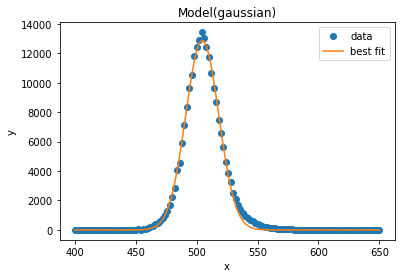

{'amplitude': 377648.0061348833, 'center': 504.5780544032583, 'sigma': 15.426221726542, 'fwhm': 36.32597544609563, 'height': 9766.47210370656}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1135649.83
    reduced chi-square = 9232.92542
    Akaike info crit   = 1153.41064
    Bayesian info crit = 1161.91949
    R-squared          = 0.99887895
[[Variables]]
    amplitude:  377648.006 +/- 1230.73007 (0.33%) (init = 508419)
    center:     504.578054 +/- 0.05805035 (0.01%) (init = 505)
    sigma:      15.4262217 +/- 0.05805035 (0.38%) (init = 17)
    fwhm:       36.3259754 +/- 0.13669812 (0.38%) == '2.3548200*sigma'
    height:     9766.47210 +/- 31.8283050 (0.33%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


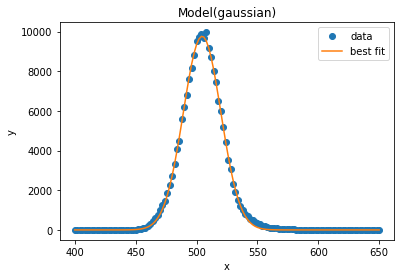

{'amplitude': 266818.2954940987, 'center': 508.4867082774707, 'sigma': 13.986348997589754, 'fwhm': 32.935334346504305, 'height': 7610.642670566771}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 555676.994
    reduced chi-square = 4517.69913
    Akaike info crit   = 1063.34923
    Bayesian info crit = 1071.85808
    R-squared          = 0.99902883
[[Variables]]
    amplitude:  266818.295 +/- 819.735996 (0.31%) (init = 347715)
    center:     508.486708 +/- 0.04961719 (0.01%) (init = 509)
    sigma:      13.9863490 +/- 0.04961720 (0.35%) (init = 15)
    fwhm:       32.9353343 +/- 0.11683956 (0.35%) == '2.3548200*sigma'
    height:     7610.64267 +/- 23.3818992 (0.31%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


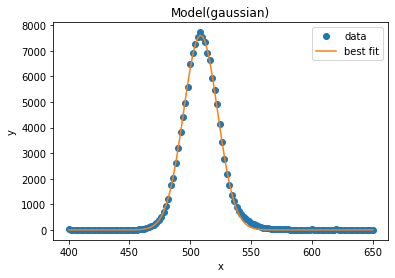

{'amplitude': 362994.42352025025, 'center': 509.25074339371014, 'sigma': 13.636924491686376, 'fwhm': 32.11250253151292, 'height': 10619.244118762053}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1514902.47
    reduced chi-square = 12316.2802
    Akaike info crit   = 1189.71704
    Bayesian info crit = 1198.22589
    R-squared          = 0.99861521
[[Variables]]
    amplitude:  362994.424 +/- 1336.47677 (0.37%) (init = 485370)
    center:     509.250743 +/- 0.05797591 (0.01%) (init = 509)
    sigma:      13.6369245 +/- 0.05797591 (0.43%) (init = 15)
    fwhm:       32.1125025 +/- 0.13652284 (0.43%) == '2.3548200*sigma'
    height:     10619.2441 +/- 39.0980668 (0.37%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


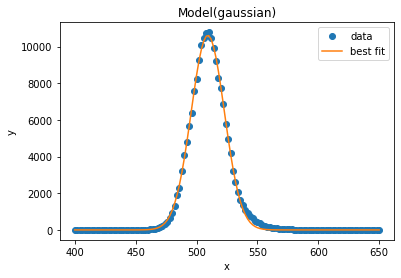

{'amplitude': 313381.581182714, 'center': 510.6342529827775, 'sigma': 12.650293109241886, 'fwhm': 29.78916321950498, 'height': 9882.867352957406}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 2030201.09
    reduced chi-square = 16505.6999
    Akaike info crit   = 1226.60780
    Bayesian info crit = 1235.11665
    R-squared          = 0.99772570
[[Variables]]
    amplitude:  313381.581 +/- 1490.15401 (0.48%) (init = 390078)
    center:     510.634253 +/- 0.06945898 (0.01%) (init = 511)
    sigma:      12.6502931 +/- 0.06945898 (0.55%) (init = 13)
    fwhm:       29.7891632 +/- 0.16356340 (0.55%) == '2.3548200*sigma'
    height:     9882.86735 +/- 46.9938646 (0.48%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


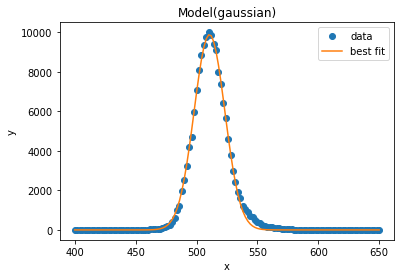

{'amplitude': 447758.10235697194, 'center': 506.84908582010405, 'sigma': 14.219763938668443, 'fwhm': 33.48498451805523, 'height': 12562.068397786139}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1533392.60
    reduced chi-square = 12466.6065
    Akaike info crit   = 1191.24563
    Bayesian info crit = 1199.75447
    R-squared          = 0.99902934
[[Variables]]
    amplitude:  447758.102 +/- 1373.04087 (0.31%) (init = 584145)
    center:     506.849086 +/- 0.05035027 (0.01%) (init = 507)
    sigma:      14.2197639 +/- 0.05035027 (0.35%) (init = 15)
    fwhm:       33.4849845 +/- 0.11856583 (0.35%) == '2.3548200*sigma'
    height:     12562.0684 +/- 38.5213240 (0.31%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


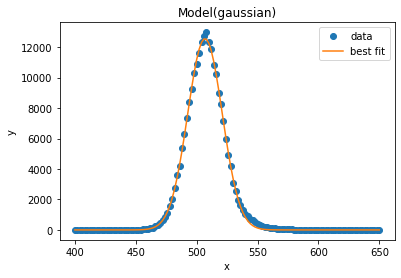

{'amplitude': 418439.9540328667, 'center': 508.1011923192428, 'sigma': 13.779027700585392, 'fwhm': 32.4471300098925, 'height': 12115.03462371834}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1622302.32
    reduced chi-square = 13189.4498
    Akaike info crit   = 1198.34745
    Bayesian info crit = 1206.85629
    R-squared          = 0.99886963
[[Variables]]
    amplitude:  418439.954 +/- 1390.22765 (0.33%) (init = 559755)
    center:     508.101192 +/- 0.05286168 (0.01%) (init = 509)
    sigma:      13.7790277 +/- 0.05286168 (0.38%) (init = 15)
    fwhm:       32.4471300 +/- 0.12447973 (0.38%) == '2.3548200*sigma'
    height:     12115.0346 +/- 40.2510838 (0.33%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


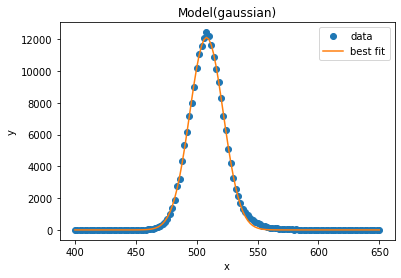

{'amplitude': 456129.6190860119, 'center': 506.71452452807085, 'sigma': 14.507051359946788, 'fwhm': 34.16149468342989, 'height': 12543.513827951663}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1736056.64
    reduced chi-square = 14114.2816
    Akaike info crit   = 1206.88646
    Bayesian info crit = 1215.39530
    R-squared          = 0.99891416
[[Variables]]
    amplitude:  456129.619 +/- 1475.64569 (0.32%) (init = 621024)
    center:     506.714525 +/- 0.05419290 (0.01%) (init = 506)
    sigma:      14.5070514 +/- 0.05419290 (0.37%) (init = 16)
    fwhm:       34.1614947 +/- 0.12761452 (0.37%) == '2.3548200*sigma'
    height:     12543.5138 +/- 40.5800959 (0.32%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


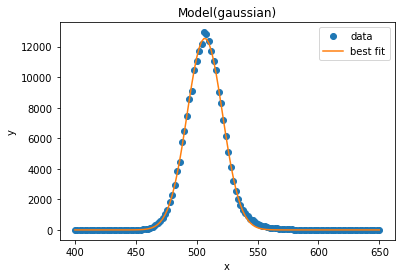

{'amplitude': 452660.11188979994, 'center': 503.44576246607744, 'sigma': 14.18570617372709, 'fwhm': 33.40478461201602, 'height': 12730.086464784572}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1314578.56
    reduced chi-square = 10687.6306
    Akaike info crit   = 1171.84584
    Bayesian info crit = 1180.35469
    R-squared          = 0.99918776
[[Variables]]
    amplitude:  452660.112 +/- 1269.78273 (0.28%) (init = 577485)
    center:     503.445762 +/- 0.04594917 (0.01%) (init = 503)
    sigma:      14.1857062 +/- 0.04594917 (0.32%) (init = 15)
    fwhm:       33.4047846 +/- 0.10820202 (0.32%) == '2.3548200*sigma'
    height:     12730.0865 +/- 35.7098994 (0.28%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


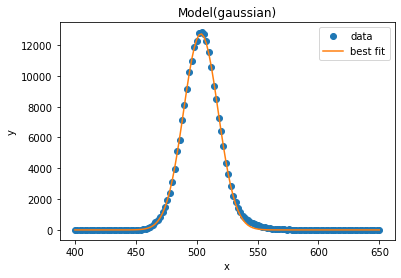

{'amplitude': 469139.30536706117, 'center': 505.4580350869526, 'sigma': 14.200737203381378, 'fwhm': 33.44017998126654, 'height': 13179.563203167556}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1567088.59
    reduced chi-square = 12740.5577
    Akaike info crit   = 1193.98447
    Bayesian info crit = 1202.49331
    R-squared          = 0.99909780
[[Variables]]
    amplitude:  469139.305 +/- 1387.11621 (0.30%) (init = 642528)
    center:     505.458035 +/- 0.04848321 (0.01%) (init = 506)
    sigma:      14.2007372 +/- 0.04848321 (0.34%) (init = 16)
    fwhm:       33.4401800 +/- 0.11416924 (0.34%) == '2.3548200*sigma'
    height:     13179.5632 +/- 38.9683585 (0.30%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


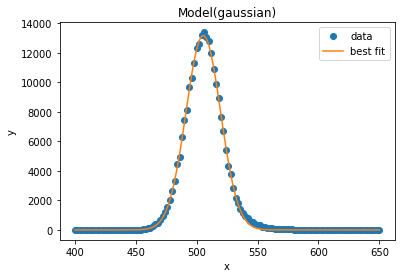

{'amplitude': 469354.92111690796, 'center': 491.23450978942145, 'sigma': 13.843590571232584, 'fwhm': 32.599163948949915, 'height': 13525.792371799838}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 3379661.16
    reduced chi-square = 27476.9200
    Akaike info crit   = 1290.82252
    Bayesian info crit = 1299.33136
    R-squared          = 0.99811348
[[Variables]]
    amplitude:  469354.921 +/- 2011.27962 (0.43%) (init = 624150)
    center:     491.234510 +/- 0.06849993 (0.01%) (init = 491)
    sigma:      13.8435906 +/- 0.06849993 (0.49%) (init = 15)
    fwhm:       32.5991639 +/- 0.16130501 (0.49%) == '2.3548200*sigma'
    height:     13525.7924 +/- 57.9608064 (0.43%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


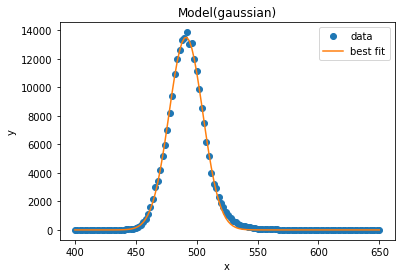

{'amplitude': 316067.14847852936, 'center': 490.4311684707032, 'sigma': 12.073518269917434, 'fwhm': 28.430962292366974, 'height': 10443.729188917549}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 2551857.88
    reduced chi-square = 20746.8120
    Akaike info crit   = 1255.42234
    Bayesian info crit = 1263.93119
    R-squared          = 0.99733855
[[Variables]]
    amplitude:  316067.148 +/- 1632.13440 (0.52%) (init = 412854)
    center:     490.431168 +/- 0.07199129 (0.01%) (init = 491)
    sigma:      12.0735183 +/- 0.07199130 (0.60%) (init = 13)
    fwhm:       28.4309623 +/- 0.16952654 (0.60%) == '2.3548200*sigma'
    height:     10443.7292 +/- 53.9302340 (0.52%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


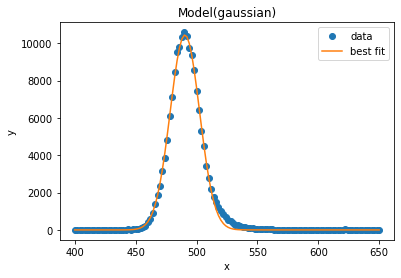

{'amplitude': 447755.2735206642, 'center': 489.27665305969384, 'sigma': 15.937887876804986, 'fwhm': 37.53085713005792, 'height': 11207.791147497515}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 3239396.35
    reduced chi-square = 26336.5557
    Akaike info crit   = 1285.48157
    Bayesian info crit = 1293.99042
    R-squared          = 0.99763370
[[Variables]]
    amplitude:  447755.274 +/- 2112.80005 (0.47%) (init = 591906)
    center:     489.276653 +/- 0.08683969 (0.02%) (init = 489)
    sigma:      15.9378879 +/- 0.08683969 (0.54%) (init = 17)
    fwhm:       37.5308571 +/- 0.20449184 (0.54%) == '2.3548200*sigma'
    height:     11207.7911 +/- 52.8856700 (0.47%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


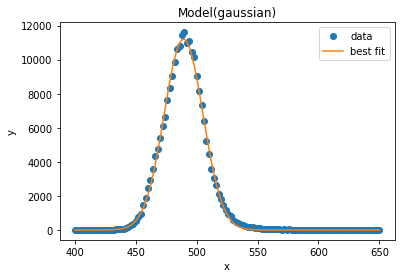

{'amplitude': 438898.6420104537, 'center': 490.9994650849082, 'sigma': 14.589622654032167, 'fwhm': 34.35593521816803, 'height': 12001.354514959685}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 2155853.67
    reduced chi-square = 17527.2656
    Akaike info crit   = 1234.17434
    Bayesian info crit = 1242.68319
    R-squared          = 0.99853294
[[Variables]]
    amplitude:  438898.642 +/- 1649.08237 (0.38%) (init = 557145)
    center:     490.999465 +/- 0.06329824 (0.01%) (init = 491)
    sigma:      14.5896227 +/- 0.06329825 (0.43%) (init = 15)
    fwhm:       34.3559352 +/- 0.14905597 (0.43%) == '2.3548200*sigma'
    height:     12001.3545 +/- 45.0929307 (0.38%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


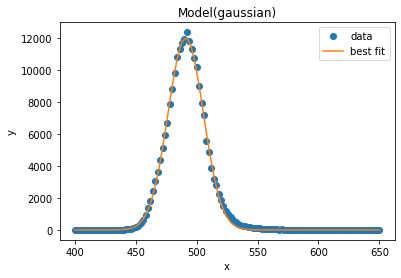

{'amplitude': 483025.86331262335, 'center': 488.9280879662212, 'sigma': 14.476355108567416, 'fwhm': 34.089210536756724, 'height': 13311.32370159806}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 126
    # variables        = 3
    chi-square         = 2010827.73
    reduced chi-square = 16348.1929
    Akaike info crit   = 1225.39966
    Bayesian info crit = 1233.90851
    R-squared          = 0.99888373
[[Variables]]
    amplitude:  483025.863 +/- 1586.45785 (0.33%) (init = 598320)
    center:     488.928088 +/- 0.05490194 (0.01%) (init = 489)
    sigma:      14.4763551 +/- 0.05490194 (0.38%) (init = 15)
    fwhm:       34.0892105 +/- 0.12928419 (0.38%) == '2.3548200*sigma'
    height:     13311.3237 +/- 43.7199864 (0.33%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


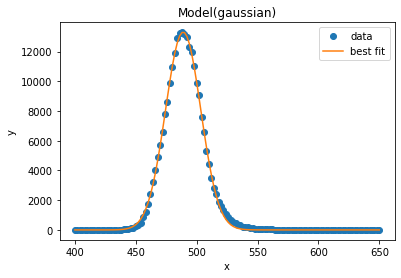

{'amplitude': 449111.0844138115, 'center': 489.22335263956285, 'sigma': 14.447482485146287, 'fwhm': 34.02122070567218, 'height': 12401.427664352415}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 2170192.89
    reduced chi-square = 17643.8447
    Akaike info crit   = 1235.00963
    Bayesian info crit = 1243.51848
    R-squared          = 0.99860875
[[Variables]]
    amplitude:  449111.084 +/- 1646.47813 (0.37%) (init = 603696)
    center:     489.223353 +/- 0.06115950 (0.01%) (init = 490)
    sigma:      14.4474825 +/- 0.06115950 (0.42%) (init = 16)
    fwhm:       34.0212207 +/- 0.14401961 (0.42%) == '2.3548200*sigma'
    height:     12401.4277 +/- 45.4646637 (0.37%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


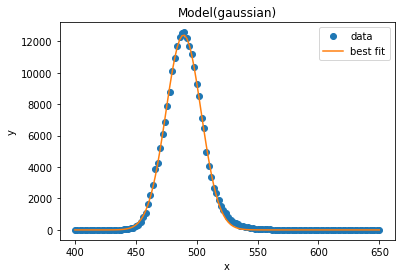

{'amplitude': 519787.98031376203, 'center': 489.9021234149999, 'sigma': 18.70992112663306, 'fwhm': 44.05849646741806, 'height': 11083.179398524988}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 3005664.53
    reduced chi-square = 24436.2970
    Akaike info crit   = 1276.04564
    Bayesian info crit = 1284.55449
    R-squared          = 0.99800663
[[Variables]]
    amplitude:  519787.980 +/- 2205.03942 (0.42%) (init = 696654)
    center:     489.902123 +/- 0.09164970 (0.02%) (init = 489)
    sigma:      18.7099211 +/- 0.09164970 (0.49%) (init = 21)
    fwhm:       44.0584965 +/- 0.21581854 (0.49%) == '2.3548200*sigma'
    height:     11083.1794 +/- 47.0169238 (0.42%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


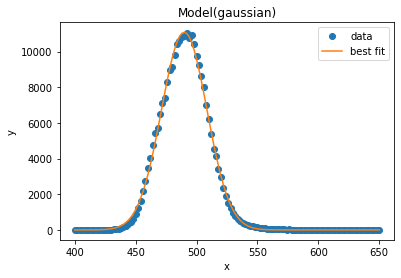

{'amplitude': 561831.2145672822, 'center': 490.6914149737256, 'sigma': 17.719002131529862, 'fwhm': 41.72506059936915, 'height': 12649.597042060572}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 5586105.50
    reduced chi-square = 45415.4919
    Akaike info crit   = 1354.13839
    Bayesian info crit = 1362.64723
    R-squared          = 0.99703612
[[Variables]]
    amplitude:  561831.215 +/- 2925.39766 (0.52%) (init = 767400)
    center:     490.691415 +/- 0.10653390 (0.02%) (init = 490)
    sigma:      17.7190021 +/- 0.10653391 (0.60%) (init = 20)
    fwhm:       41.7250606 +/- 0.25086817 (0.60%) == '2.3548200*sigma'
    height:     12649.5970 +/- 65.8651758 (0.52%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


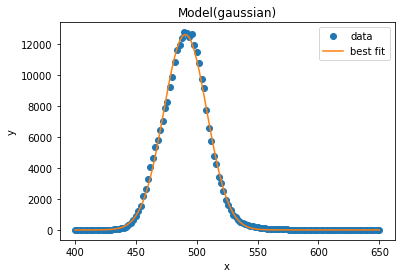

{'amplitude': 452023.339882393, 'center': 499.8602224382357, 'sigma': 17.905595737001406, 'fwhm': 42.16445495340565, 'height': 10071.222064603762}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 14878849.4
    reduced chi-square = 120966.256
    Akaike info crit   = 1477.57534
    Bayesian info crit = 1486.08418
    R-squared          = 0.98768002
[[Variables]]
    amplitude:  452023.340 +/- 4799.42449 (1.06%) (init = 576180)
    center:     499.860222 +/- 0.21952603 (0.04%) (init = 500)
    sigma:      17.9055957 +/- 0.21952603 (1.23%) (init = 18)
    fwhm:       42.1644550 +/- 0.51694429 (1.23%) == '2.3548200*sigma'
    height:     10071.2221 +/- 106.932617 (1.06%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


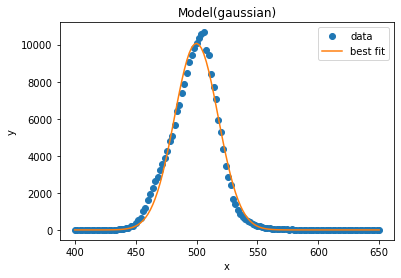

{'amplitude': 600589.1755600307, 'center': 490.7619874380764, 'sigma': 18.555235020225243, 'fwhm': 43.69423853032681, 'height': 12912.820925838854}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 5563106.12
    reduced chi-square = 45228.5050
    Akaike info crit   = 1353.61854
    Bayesian info crit = 1362.12739
    R-squared          = 0.99725589
[[Variables]]
    amplitude:  600589.176 +/- 2987.46283 (0.50%) (init = 785520)
    center:     490.761987 +/- 0.10657637 (0.02%) (init = 490)
    sigma:      18.5552350 +/- 0.10657637 (0.57%) (init = 20)
    fwhm:       43.6942385 +/- 0.25096816 (0.57%) == '2.3548200*sigma'
    height:     12912.8209 +/- 64.2312218 (0.50%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


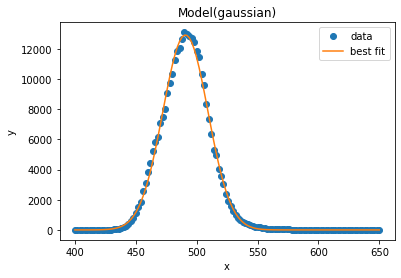

{'amplitude': 252201.44474282005, 'center': 503.8678879080005, 'sigma': 12.33399769652608, 'fwhm': 29.044344455733544, 'height': 8157.4382373495855}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 2828869.08
    reduced chi-square = 22998.9356
    Akaike info crit   = 1268.40731
    Bayesian info crit = 1276.91616
    R-squared          = 0.99526125
[[Variables]]
    amplitude:  252201.445 +/- 1736.87906 (0.69%) (init = 326352)
    center:     503.867888 +/- 0.09808349 (0.02%) (init = 503)
    sigma:      12.3339977 +/- 0.09808349 (0.80%) (init = 13)
    fwhm:       29.0443445 +/- 0.23096897 (0.80%) == '2.3548200*sigma'
    height:     8157.43824 +/- 56.1792911 (0.69%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


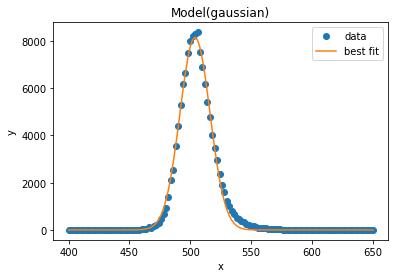

{'amplitude': 283585.45795472316, 'center': 498.74359062462116, 'sigma': 11.754322061770269, 'fwhm': 27.679312677497865, 'height': 9624.905141145324}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 4156119.44
    reduced chi-square = 33789.5890
    Akaike info crit   = 1316.88012
    Bayesian info crit = 1325.38896
    R-squared          = 0.99480038
[[Variables]]
    amplitude:  283585.458 +/- 2055.19117 (0.72%) (init = 351684)
    center:     498.743591 +/- 0.09836353 (0.02%) (init = 498)
    sigma:      11.7543221 +/- 0.09836353 (0.84%) (init = 12)
    fwhm:       27.6793127 +/- 0.23162841 (0.84%) == '2.3548200*sigma'
    height:     9624.90514 +/- 69.7531756 (0.72%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


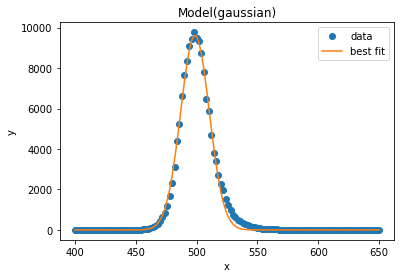

{'amplitude': 1934.0970949636835, 'center': 496.9760557464799, 'sigma': 16.511358798994756, 'fwhm': 38.881277927048835, 'height': 46.7310505986404}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 4123.00141
    reduced chi-square = 33.5203366
    Akaike info crit   = 445.494901
    Bayesian info crit = 454.003746
    R-squared          = 0.81742603
[[Variables]]
    amplitude:  1934.09709 +/- 76.7212840 (3.97%) (init = 2499)
    center:     496.976056 +/- 0.75630495 (0.15%) (init = 497)
    sigma:      16.5113588 +/- 0.75630488 (4.58%) (init = 17)
    fwhm:       38.8812779 +/- 1.78096187 (4.58%) == '2.3548200*sigma'
    height:     46.7310506 +/- 1.85373601 (3.97%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


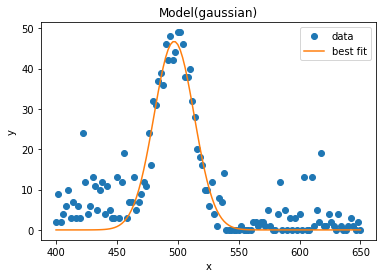

{'amplitude': 279592.58589899045, 'center': 492.8589495112888, 'sigma': 11.80759562438553, 'fwhm': 27.804762328215535, 'height': 9446.57259866955}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 3015381.05
    reduced chi-square = 24515.2931
    Akaike info crit   = 1276.45231
    Bayesian info crit = 1284.96116
    R-squared          = 0.99608739
[[Variables]]
    amplitude:  279592.586 +/- 1754.53871 (0.63%) (init = 371592)
    center:     492.858950 +/- 0.08555959 (0.02%) (init = 493)
    sigma:      11.8075956 +/- 0.08555959 (0.72%) (init = 13)
    fwhm:       27.8047623 +/- 0.20147744 (0.72%) == '2.3548200*sigma'
    height:     9446.57260 +/- 59.2805123 (0.63%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


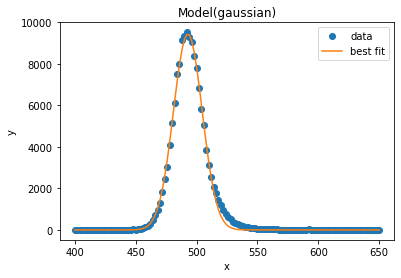

{'amplitude': 60968.60462288458, 'center': 498.55187719107323, 'sigma': 11.18204356117272, 'fwhm': 26.331699818720743, 'height': 2175.1798070703753}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 212247.725
    reduced chi-square = 1725.59126
    Akaike info crit   = 942.082663
    Bayesian info crit = 950.591508
    R-squared          = 0.99457637
[[Variables]]
    amplitude:  60968.6046 +/- 452.994735 (0.74%) (init = 79560)
    center:     498.551877 +/- 0.09593519 (0.02%) (init = 498)
    sigma:      11.1820436 +/- 0.09593519 (0.86%) (init = 12)
    fwhm:       26.3316998 +/- 0.22591012 (0.86%) == '2.3548200*sigma'
    height:     2175.17981 +/- 16.1615277 (0.74%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


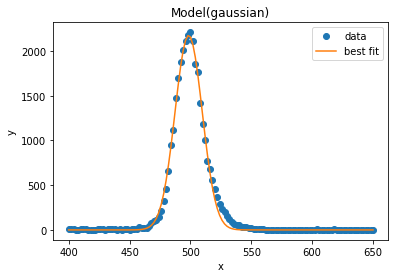

{'amplitude': 108882.25384326064, 'center': 496.29612496087856, 'sigma': 11.15577220959161, 'fwhm': 26.26983551459052, 'height': 3893.7454047391675}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 533046.243
    reduced chi-square = 4333.70929
    Akaike info crit   = 1058.11028
    Bayesian info crit = 1066.61912
    R-squared          = 0.99573623
[[Variables]]
    amplitude:  108882.254 +/- 717.039676 (0.66%) (init = 141480)
    center:     496.296125 +/- 0.08483117 (0.02%) (init = 496)
    sigma:      11.1557722 +/- 0.08483117 (0.76%) (init = 12)
    fwhm:       26.2698355 +/- 0.19976215 (0.76%) == '2.3548200*sigma'
    height:     3893.74540 +/- 25.6421180 (0.66%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


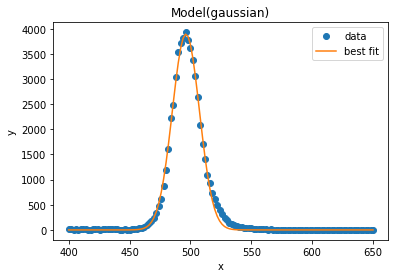

{'amplitude': 74302.71573664741, 'center': 498.9227216312501, 'sigma': 11.155142427824146, 'fwhm': 26.268352491888855, 'height': 2657.294293104441}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 245736.255
    reduced chi-square = 1997.85573
    Akaike info crit   = 960.542257
    Bayesian info crit = 969.051103
    R-squared          = 0.99578845
[[Variables]]
    amplitude:  74302.7157 +/- 486.835421 (0.66%) (init = 87615)
    center:     498.922722 +/- 0.08439591 (0.02%) (init = 499)
    sigma:      11.1551424 +/- 0.08439592 (0.76%) (init = 11)
    fwhm:       26.2683525 +/- 0.19873719 (0.76%) == '2.3548200*sigma'
    height:     2657.29429 +/- 17.4107219 (0.66%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


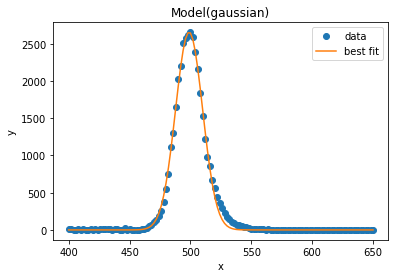

{'amplitude': 402846.9121958113, 'center': 495.13027112128333, 'sigma': 17.17051037415505, 'fwhm': 40.4334612392678, 'height': 9359.807611845876}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 5406831.60
    reduced chi-square = 43957.9805
    Akaike info crit   = 1350.02838
    Bayesian info crit = 1358.53723
    R-squared          = 0.99465210
[[Variables]]
    amplitude:  402846.912 +/- 2833.17681 (0.70%) (init = 524340)
    center:     495.130271 +/- 0.13943966 (0.03%) (init = 496)
    sigma:      17.1705104 +/- 0.13943966 (0.81%) (init = 18)
    fwhm:       40.4334612 +/- 0.32835531 (0.81%) == '2.3548200*sigma'
    height:     9359.80761 +/- 65.8264802 (0.70%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


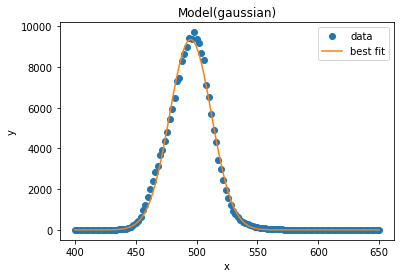

{'amplitude': 3035.203426748539, 'center': 500.46085443478995, 'sigma': 18.477659901769208, 'fwhm': 43.51156308988417, 'height': 65.5316226444348}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 126
    # variables        = 3
    chi-square         = 5735.59566
    reduced chi-square = 46.6308590
    Akaike info crit   = 487.088788
    Bayesian info crit = 495.597633
    R-squared          = 0.87548869
[[Variables]]
    amplitude:  3035.20343 +/- 95.7230864 (3.15%) (init = 3825)
    center:     500.460854 +/- 0.67288155 (0.13%) (init = 501)
    sigma:      18.4776599 +/- 0.67288161 (3.64%) (init = 17)
    fwhm:       43.5115631 +/- 1.58451509 (3.64%) == '2.3548200*sigma'
    height:     65.5316226 +/- 2.06669044 (3.15%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


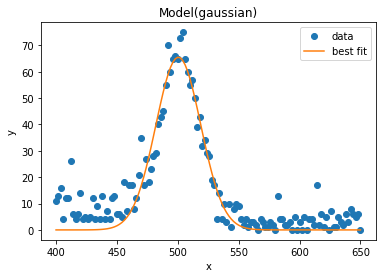

{'amplitude': 467721.87078021426, 'center': 488.8043707694414, 'sigma': 17.788337107912827, 'fwhm': 41.888331988455285, 'height': 10489.684210355921}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 3862004.95
    reduced chi-square = 31398.4142
    Akaike info crit   = 1307.63230
    Bayesian info crit = 1316.14115
    R-squared          = 0.99703166
[[Variables]]
    amplitude:  467721.871 +/- 2437.16300 (0.52%) (init = 612579)
    center:     488.804371 +/- 0.10702902 (0.02%) (init = 489)
    sigma:      17.7883371 +/- 0.10702903 (0.60%) (init = 19)
    fwhm:       41.8883320 +/- 0.25203409 (0.60%) == '2.3548200*sigma'
    height:     10489.6842 +/- 54.6586978 (0.52%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


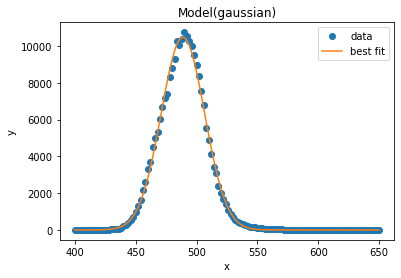

{'amplitude': 445409.75934362854, 'center': 485.83646892141314, 'sigma': 17.06618981042423, 'fwhm': 40.18780508938319, 'height': 10411.978057718356}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 3453649.94
    reduced chi-square = 28078.4548
    Akaike info crit   = 1293.55119
    Bayesian info crit = 1302.06004
    R-squared          = 0.99722810
[[Variables]]
    amplitude:  445409.759 +/- 2257.44871 (0.51%) (init = 604542)
    center:     485.836469 +/- 0.09987666 (0.02%) (init = 485)
    sigma:      17.0661898 +/- 0.09987666 (0.59%) (init = 19)
    fwhm:       40.1878051 +/- 0.23519156 (0.59%) == '2.3548200*sigma'
    height:     10411.9781 +/- 52.7705172 (0.51%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


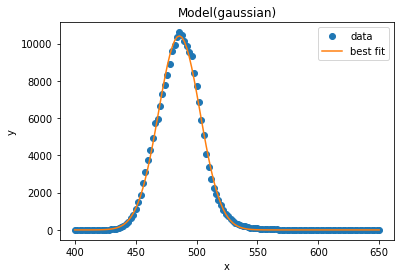

{'amplitude': 325740.58271144977, 'center': 490.41691670956544, 'sigma': 19.98481954988228, 'fwhm': 47.06065277245379, 'height': 6502.520422858234}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 6821513.76
    reduced chi-square = 55459.4615
    Akaike info crit   = 1379.31307
    Bayesian info crit = 1387.82191
    R-squared          = 0.98755782
[[Variables]]
    amplitude:  325740.583 +/- 3433.22246 (1.05%) (init = 456021)
    center:     490.416917 +/- 0.24322073 (0.05%) (init = 489)
    sigma:      19.9848195 +/- 0.24322073 (1.22%) (init = 23)
    fwhm:       47.0606528 +/- 0.57274105 (1.22%) == '2.3548200*sigma'
    height:     6502.52042 +/- 68.5349983 (1.05%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


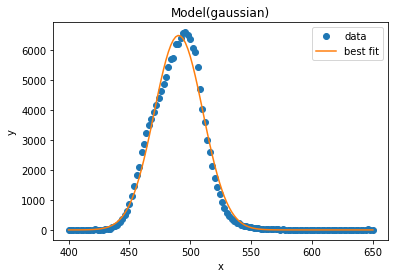

{'amplitude': 385764.9926123246, 'center': 482.0637185924935, 'sigma': 16.870904002040522, 'fwhm': 39.727942162085064, 'height': 9122.094073538085}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1700602.88
    reduced chi-square = 13826.0397
    Akaike info crit   = 1204.28665
    Bayesian info crit = 1212.79549
    R-squared          = 0.99820988
[[Variables]]
    amplitude:  385764.993 +/- 1574.99939 (0.41%) (init = 547680)
    center:     482.063719 +/- 0.07953614 (0.02%) (init = 482)
    sigma:      16.8709040 +/- 0.07953614 (0.47%) (init = 20)
    fwhm:       39.7279422 +/- 0.18729330 (0.47%) == '2.3548200*sigma'
    height:     9122.09407 +/- 37.2435949 (0.41%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


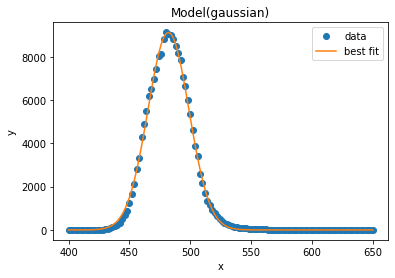

{'amplitude': 366772.5666820651, 'center': 481.0314643543083, 'sigma': 17.823519718618353, 'fwhm': 41.971180703796875, 'height': 8209.43863159644}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 1818036.05
    reduced chi-square = 14780.7809
    Akaike info crit   = 1212.70017
    Bayesian info crit = 1221.20902
    R-squared          = 0.99772848
[[Variables]]
    amplitude:  366772.567 +/- 1673.81963 (0.46%) (init = 513198)
    center:     481.031464 +/- 0.09392361 (0.02%) (init = 481)
    sigma:      17.8235197 +/- 0.09392361 (0.53%) (init = 21)
    fwhm:       41.9711807 +/- 0.22117320 (0.53%) == '2.3548200*sigma'
    height:     8209.43863 +/- 37.4649679 (0.46%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


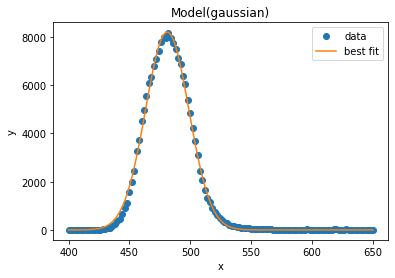

{'amplitude': 418121.78455901187, 'center': 484.76539056129104, 'sigma': 16.1809370211252, 'fwhm': 38.103194116086044, 'height': 10308.826132522528}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1814983.57
    reduced chi-square = 14755.9640
    Akaike info crit   = 1212.48844
    Bayesian info crit = 1220.99728
    R-squared          = 0.99845554
[[Variables]]
    amplitude:  418121.785 +/- 1593.48765 (0.38%) (init = 564624)
    center:     484.765391 +/- 0.07120638 (0.01%) (init = 484)
    sigma:      16.1809370 +/- 0.07120638 (0.44%) (init = 18)
    fwhm:       38.1031941 +/- 0.16767821 (0.44%) == '2.3548200*sigma'
    height:     10308.8261 +/- 39.2875643 (0.38%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


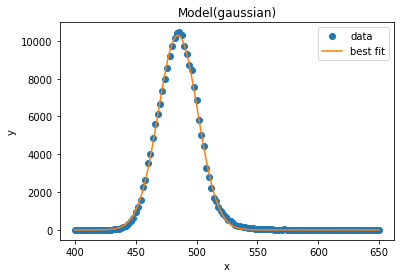

{'amplitude': 432076.3294906344, 'center': 484.1789897766791, 'sigma': 17.20622264075369, 'fwhm': 40.51755719889961, 'height': 10018.092190338006}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 2266380.20
    reduced chi-square = 18425.8553
    Akaike info crit   = 1240.47399
    Bayesian info crit = 1248.98283
    R-squared          = 0.99804565
[[Variables]]
    amplitude:  432076.329 +/- 1836.19850 (0.42%) (init = 579006)
    center:     484.178990 +/- 0.08443334 (0.02%) (init = 483)
    sigma:      17.2062226 +/- 0.08443334 (0.49%) (init = 19)
    fwhm:       40.5175572 +/- 0.19882533 (0.49%) == '2.3548200*sigma'
    height:     10018.0922 +/- 42.5739677 (0.42%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


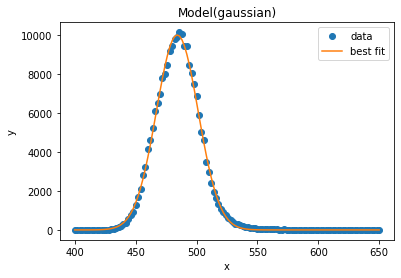

{'amplitude': 440270.1061608085, 'center': 487.2917964097535, 'sigma': 18.94736379606418, 'fwhm': 44.61763121424786, 'height': 9270.016170245393}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 3313290.61
    reduced chi-square = 26937.3221
    Akaike info crit   = 1288.32348
    Bayesian info crit = 1296.83233
    R-squared          = 0.99687987
[[Variables]]
    amplitude:  440270.106 +/- 2329.77485 (0.53%) (init = 613338)
    center:     487.291796 +/- 0.11577430 (0.02%) (init = 486)
    sigma:      18.9473638 +/- 0.11577431 (0.61%) (init = 22)
    fwhm:       44.6176312 +/- 0.27262765 (0.61%) == '2.3548200*sigma'
    height:     9270.01617 +/- 49.0540367 (0.53%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


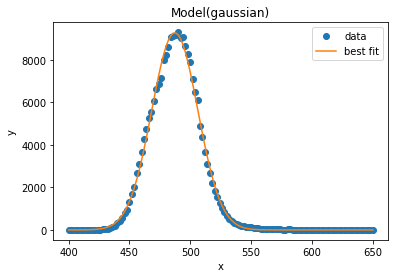

{'amplitude': 470685.36866695934, 'center': 485.87747242069054, 'sigma': 15.84788527669794, 'fwhm': 37.31891720727385, 'height': 11848.666258863132}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 2403741.13
    reduced chi-square = 19542.6108
    Akaike info crit   = 1247.88813
    Bayesian info crit = 1256.39697
    R-squared          = 0.99842711
[[Variables]]
    amplitude:  470685.369 +/- 1814.84692 (0.39%) (init = 677844)
    center:     485.877472 +/- 0.07055860 (0.01%) (init = 485)
    sigma:      15.8478853 +/- 0.07055860 (0.45%) (init = 19)
    fwhm:       37.3189172 +/- 0.16615280 (0.45%) == '2.3548200*sigma'
    height:     11848.6663 +/- 45.6855373 (0.39%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


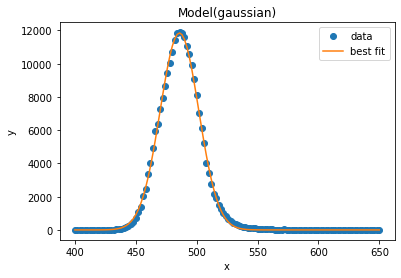

{'amplitude': 461894.42530183017, 'center': 483.8846332144298, 'sigma': 17.486685962302687, 'fwhm': 41.177997837749615, 'height': 10537.687059991402}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 2176182.53
    reduced chi-square = 17692.5409
    Akaike info crit   = 1235.35691
    Bayesian info crit = 1243.86575
    R-squared          = 0.99832398
[[Variables]]
    amplitude:  461894.425 +/- 1813.89349 (0.39%) (init = 638880)
    center:     483.884633 +/- 0.07929499 (0.02%) (init = 484)
    sigma:      17.4866860 +/- 0.07929499 (0.45%) (init = 20)
    fwhm:       41.1779978 +/- 0.18672544 (0.45%) == '2.3548200*sigma'
    height:     10537.6871 +/- 41.3822632 (0.39%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


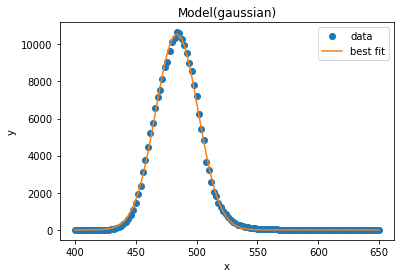

{'amplitude': 452262.56488506694, 'center': 488.7481102083688, 'sigma': 17.97475808242901, 'fwhm': 42.327319827665484, 'height': 10037.780036412372}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 4530738.70
    reduced chi-square = 36835.2740
    Akaike info crit   = 1327.75432
    Bayesian info crit = 1336.26317
    R-squared          = 0.99621997
[[Variables]]
    amplitude:  452262.565 +/- 2653.54804 (0.59%) (init = 615600)
    center:     488.748110 +/- 0.12177808 (0.02%) (init = 488)
    sigma:      17.9747581 +/- 0.12177808 (0.68%) (init = 20)
    fwhm:       42.3273198 +/- 0.28676546 (0.68%) == '2.3548200*sigma'
    height:     10037.7800 +/- 58.8944329 (0.59%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


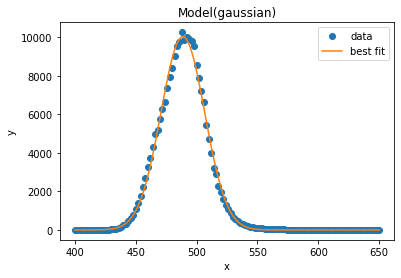

In [ ]:

data = Readone
result_readone= np.zeros((data.shape[0],data.shape[1],4))
x = luminescence_wavelength  #np.arange(dat.shape[0])


 
fwhm=[]
center=[]
height=[]
fit_data=[]
for i in range (40):
  y=data[:,i]
  mod = GaussianModel()
  pars = mod.guess(y, x=x)
  result = mod.fit(y, pars, x=x) 
  val= result.params.valuesdict()
  f= np.array(val['fwhm'])
  fwhm.append(f)
  c= np.array(val['center'])
  center.append(c)
  h=np.array(val['height'])

  print(result.params.valuesdict())
  para=result.fit_report()
  print(result.fit_report())
  
  result.plot_fit()
      
      
  plt.show()
  
  



### Bar plot for Read One

## Intensity Bar plot

In [ ]:
intensity_bar= pd.DataFrame(height)
intensity_bar.rename(columns={intensity_bar.columns[0]: 'Height'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

intensity_bar['wells']=wells

print(intensity_bar)

          Height  wells
0   12896.540468  1:0.1
1    9766.472104  1:0.2
2    7610.642671  1:0.3
3   10619.244119  1:0.4
4    9882.867353  1:0.5
5   12562.068398  1:0.6
6   12115.034624  1:0.7
7   12543.513828  1:0.8
8   12730.086465  1:0.9
9   13179.563203    1:1
10  13525.792372  1:1.1
11  10443.729189  1:1.2
12  11207.791147  1:1.3
13  12001.354515  1:1.4
14  13311.323702  1:1.5
15  12401.427664  1:1.6
16  11083.179399  1:1.7
17  12649.597042  1:1.8
18  10071.222065  1:1.9
19  12912.820926    1:2
20   8157.438237  1:0.1
21   9624.905141  1:0.2
22     46.731051  1:0.3
23   9446.572599  1:0.4
24   2175.179807  1:0.5
25   3893.745405  1:0.6
26   2657.294293  1:0.7
27   9359.807612  1:0.8
28     65.531623  1:0.9
29  10489.684210    1:1
30  10411.978058  1:1.1
31   6502.520423  1:1.2
32   9122.094074  1:1.3
33   8209.438632  1:1.4
34  10308.826133  1:1.5
35  10018.092190  1:1.6
36   9270.016170  1:1.7
37  11848.666259  1:1.8
38  10537.687060  1:1.9
39  10037.780036    1:2


Text(0.5, 1.0, '150 ul PbBr2')

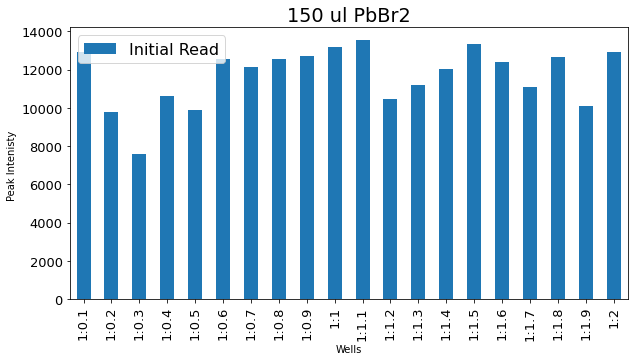

In [ ]:

plotdata= intensity_bar[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(10,5),cmap=cmap);


ax.set_xlabel("Wells")
ax.set_ylabel("Peak Intenisty ")
ax.set_xticklabels(intensity_bar['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'])

ax.set_title('150 ul PbBr2')

##FWHM Bar Plot

In [ ]:
fwhm_bar= pd.DataFrame(fwhm)
fwhm_bar.rename(columns={fwhm_bar.columns[0]: 'fwhm'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

fwhm_bar['wells']=wells

print(fwhm_bar)

         fwhm  wells
0   31.896584  1:0.1
1   36.325975  1:0.2
2   32.935334  1:0.3
3   32.112503  1:0.4
4   29.789163  1:0.5
5   33.484985  1:0.6
6   32.447130  1:0.7
7   34.161495  1:0.8
8   33.404785  1:0.9
9   33.440180    1:1
10  32.599164  1:1.1
11  28.430962  1:1.2
12  37.530857  1:1.3
13  34.355935  1:1.4
14  34.089211  1:1.5
15  34.021221  1:1.6
16  44.058496  1:1.7
17  41.725061  1:1.8
18  42.164455  1:1.9
19  43.694239    1:2
20  29.044344  1:0.1
21  27.679313  1:0.2
22  38.881278  1:0.3
23  27.804762  1:0.4
24  26.331700  1:0.5
25  26.269836  1:0.6
26  26.268352  1:0.7
27  40.433461  1:0.8
28  43.511563  1:0.9
29  41.888332    1:1
30  40.187805  1:1.1
31  47.060653  1:1.2
32  39.727942  1:1.3
33  41.971181  1:1.4
34  38.103194  1:1.5
35  40.517557  1:1.6
36  44.617631  1:1.7
37  37.318917  1:1.8
38  41.177998  1:1.9
39  42.327320    1:2


Text(0.5, 1.0, '300 ul PbBr2')

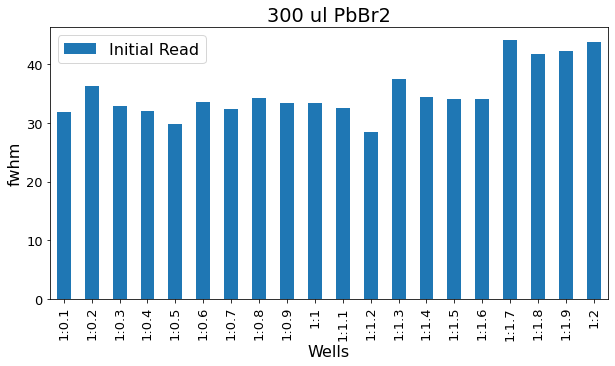

In [ ]:

plotdata= fwhm_bar[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(10,5),cmap=cmap);


ax.set_xlabel("Wells")
ax.set_ylabel("fwhm")
ax.set_xticklabels(fwhm_bar['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'])

ax.set_title('300 ul PbBr2')

##Center Bar Plot for Read Initial

In [ ]:
center_bar= pd.DataFrame(center)
center_bar.rename(columns={center_bar.columns[0]: 'center'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

center_bar['wells']=wells

print(center_bar)

        center  wells
0   504.590614  1:0.1
1   504.578054  1:0.2
2   508.486708  1:0.3
3   509.250743  1:0.4
4   510.634253  1:0.5
5   506.849086  1:0.6
6   508.101192  1:0.7
7   506.714525  1:0.8
8   503.445762  1:0.9
9   505.458035    1:1
10  491.234510  1:1.1
11  490.431168  1:1.2
12  489.276653  1:1.3
13  490.999465  1:1.4
14  488.928088  1:1.5
15  489.223353  1:1.6
16  489.902123  1:1.7
17  490.691415  1:1.8
18  499.860222  1:1.9
19  490.761987    1:2
20  503.867888  1:0.1
21  498.743591  1:0.2
22  496.976056  1:0.3
23  492.858950  1:0.4
24  498.551877  1:0.5
25  496.296125  1:0.6
26  498.922722  1:0.7
27  495.130271  1:0.8
28  500.460854  1:0.9
29  488.804371    1:1
30  485.836469  1:1.1
31  490.416917  1:1.2
32  482.063719  1:1.3
33  481.031464  1:1.4
34  484.765391  1:1.5
35  484.178990  1:1.6
36  487.291796  1:1.7
37  485.877472  1:1.8
38  483.884633  1:1.9
39  488.748110    1:2


Text(0.5, 1.0, '300 ul PbBr2')

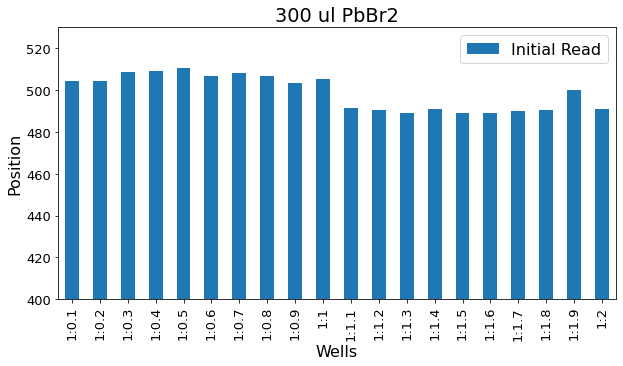

In [ ]:

plotdata= center_bar[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(10,5),cmap=cmap);

plt.ylim([400, 530])
ax.set_xlabel("Wells")
ax.set_ylabel("Position")
ax.set_xticklabels(center_bar['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'])

ax.set_title('300 ul PbBr2')

## Gaussian Fit for Final Read

In [ ]:
Readfinal= np.array(d['Read 92'].drop(['Wavelength'],axis=1))

{'amplitude': 17623.37130698384, 'center': 514.8775481480573, 'sigma': 13.476495990715353, 'fwhm': 31.73472228885633, 'height': 521.7015081521157}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 12397.0050
    reduced chi-square = 100.788658
    Akaike info crit   = 584.204963
    Bayesian info crit = 592.713809
    R-squared          = 0.99514255
[[Variables]]
    amplitude:  17623.3713 +/- 120.187010 (0.68%) (init = 23355)
    center:     514.877548 +/- 0.10612434 (0.02%) (init = 515)
    sigma:      13.4764960 +/- 0.10612434 (0.79%) (init = 15)
    fwhm:       31.7347223 +/- 0.24990373 (0.79%) == '2.3548200*sigma'
    height:     521.701508 +/- 3.55787521 (0.68%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


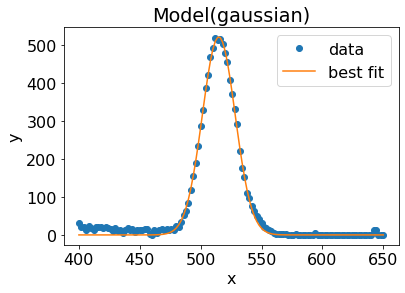

{'amplitude': 23350.983191673902, 'center': 506.2748680710371, 'sigma': 11.76498410092133, 'fwhm': 27.70441986053157, 'height': 791.8153447413673}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 27245.9304
    reduced chi-square = 221.511630
    Akaike info crit   = 683.423570
    Bayesian info crit = 691.932416
    R-squared          = 0.99488610
[[Variables]]
    amplitude:  23350.9832 +/- 166.478143 (0.71%) (init = 29376)
    center:     506.274868 +/- 0.09685297 (0.02%) (init = 506)
    sigma:      11.7649841 +/- 0.09685297 (0.82%) (init = 12)
    fwhm:       27.7044199 +/- 0.22807132 (0.82%) == '2.3548200*sigma'
    height:     791.815345 +/- 5.64515789 (0.71%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


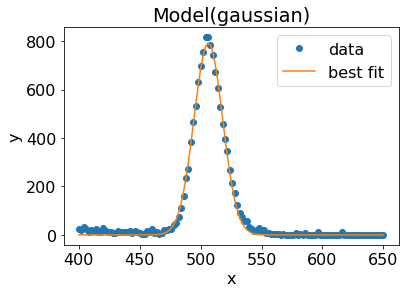

{'amplitude': 3389.221846179441, 'center': 509.84195306954166, 'sigma': 12.525083639029287, 'fwhm': 29.494317454858948, 'height': 107.95169098207018}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 9091.63913
    reduced chi-square = 73.9157653
    Akaike info crit   = 545.132402
    Bayesian info crit = 553.641248
    R-squared          = 0.90744794
[[Variables]]
    amplitude:  3389.22185 +/- 99.2259234 (2.93%) (init = 4578)
    center:     509.841953 +/- 0.42342681 (0.08%) (init = 510)
    sigma:      12.5250836 +/- 0.42342678 (3.38%) (init = 14)
    fwhm:       29.4943175 +/- 0.99709386 (3.38%) == '2.3548200*sigma'
    height:     107.951691 +/- 3.16050668 (2.93%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


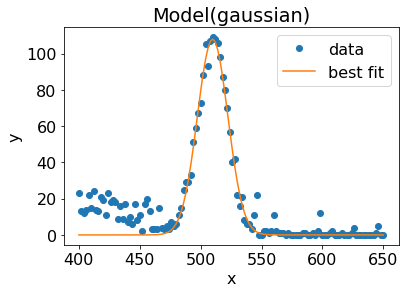

{'amplitude': 8784.49126548792, 'center': 506.5817647385594, 'sigma': 11.077048869643777, 'fwhm': 26.08445621921456, 'height': 316.3753442839476}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 10621.7208
    reduced chi-square = 86.3554539
    Akaike info crit   = 564.731176
    Bayesian info crit = 573.240022
    R-squared          = 0.98666262
[[Variables]]
    amplitude:  8784.49127 +/- 100.860953 (1.15%) (init = 11628)
    center:     506.581765 +/- 0.14685981 (0.03%) (init = 506)
    sigma:      11.0770489 +/- 0.14685979 (1.33%) (init = 12)
    fwhm:       26.0844562 +/- 0.34582838 (1.33%) == '2.3548200*sigma'
    height:     316.375344 +/- 3.63254578 (1.15%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


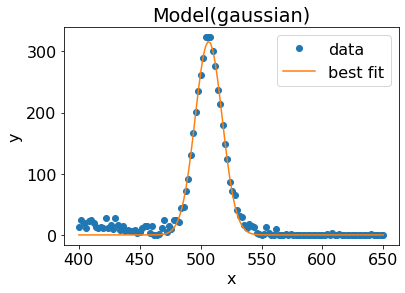

{'amplitude': 20656.62433371113, 'center': 505.9123906009019, 'sigma': 11.030434091174357, 'fwhm': 25.9746868065792, 'height': 747.0967283617872}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 25957.8198
    reduced chi-square = 211.039186
    Akaike info crit   = 677.321231
    Bayesian info crit = 685.830077
    R-squared          = 0.99418870
[[Variables]]
    amplitude:  20656.6243 +/- 157.340842 (0.76%) (init = 27576)
    center:     505.912391 +/- 0.09701628 (0.02%) (init = 506)
    sigma:      11.0304341 +/- 0.09701628 (0.88%) (init = 12)
    fwhm:       25.9746868 +/- 0.22845587 (0.88%) == '2.3548200*sigma'
    height:     747.096728 +/- 5.69061622 (0.76%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


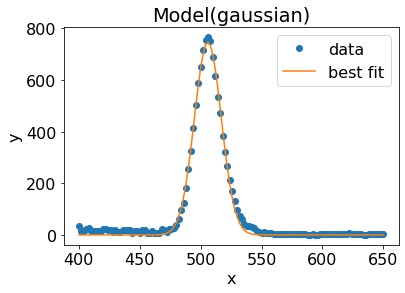

{'amplitude': 1830.6703456070827, 'center': 509.91129245860475, 'sigma': 13.977093159454528, 'fwhm': 32.913538513746715, 'height': 52.25205483618502}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 126
    # variables        = 3
    chi-square         = 9921.39687
    reduced chi-square = 80.6617632
    Akaike info crit   = 556.137054
    Bayesian info crit = 564.645900
    R-squared          = 0.63171172
[[Variables]]
    amplitude:  1830.67035 +/- 109.494529 (5.98%) (init = 2340)
    center:     509.911292 +/- 0.96528498 (0.19%) (init = 511)
    sigma:      13.9770932 +/- 0.96528524 (6.91%) (init = 13)
    fwhm:       32.9135385 +/- 2.27307299 (6.91%) == '2.3548200*sigma'
    height:     52.2520548 +/- 3.12519476 (5.98%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


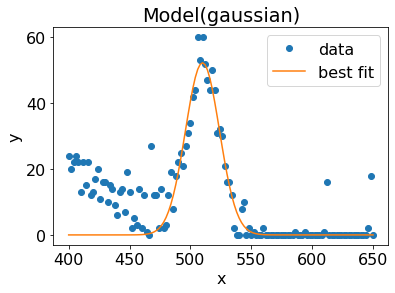

{'amplitude': 4610.5137138258715, 'center': 507.85593677271794, 'sigma': 12.353719564075803, 'fwhm': 29.090785903876984, 'height': 148.88867564421173}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 10585.1270
    reduced chi-square = 86.0579431
    Akaike info crit   = 564.296333
    Bayesian info crit = 572.805178
    R-squared          = 0.94292933
[[Variables]]
    amplitude:  4610.51371 +/- 106.330065 (2.31%) (init = 5688)
    center:     507.855937 +/- 0.32898227 (0.06%) (init = 508)
    sigma:      12.3537196 +/- 0.32898229 (2.66%) (init = 12)
    fwhm:       29.0907859 +/- 0.77469408 (2.66%) == '2.3548200*sigma'
    height:     148.888676 +/- 3.43374093 (2.31%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


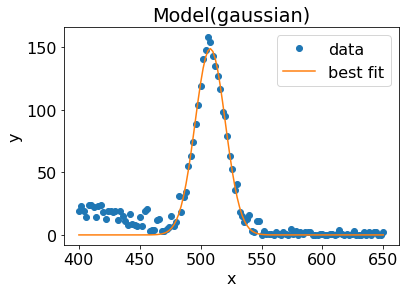

{'amplitude': 3438.068429595526, 'center': 420.3726617980641, 'sigma': 92.94915822470671, 'fwhm': 218.87853677070387, 'height': 14.756356626107094}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 126
    # variables        = 3
    chi-square         = 6335.89002
    reduced chi-square = 51.5113009
    Akaike info crit   = 499.630662
    Bayesian info crit = 508.139508
    R-squared          = 0.37294087
[[Variables]]
    amplitude:  3438.06843 +/- 979.517734 (28.49%) (init = 5841)
    center:     420.372662 +/- 30.7446732 (7.31%) (init = 471.7)
    sigma:      92.9491582 +/- 22.1684765 (23.85%) (init = 59)
    fwhm:       218.878537 +/- 52.2027718 (23.85%) == '2.3548200*sigma'
    height:     14.7563566 +/- 1.42768770 (9.68%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.947
    C(amplitude, center) = -0.946
    C(center

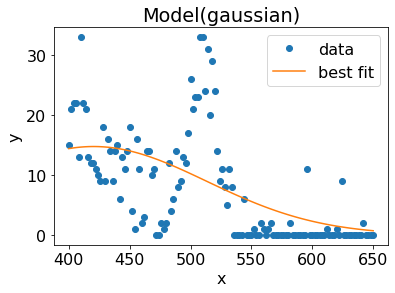

{'amplitude': 3113.937787526211, 'center': 505.6805950913387, 'sigma': 12.615766332260504, 'fwhm': 29.70785887453368, 'height': 98.47055424892488}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 8658.51201
    reduced chi-square = 70.3944066
    Akaike info crit   = 538.982048
    Bayesian info crit = 547.490894
    R-squared          = 0.89340839
[[Variables]]
    amplitude:  3113.93779 +/- 97.1819489 (3.12%) (init = 3744)
    center:     505.680595 +/- 0.45462706 (0.09%) (init = 506)
    sigma:      12.6157663 +/- 0.45462710 (3.60%) (init = 12)
    fwhm:       29.7078589 +/- 1.07056500 (3.60%) == '2.3548200*sigma'
    height:     98.4705542 +/- 3.07312210 (3.12%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


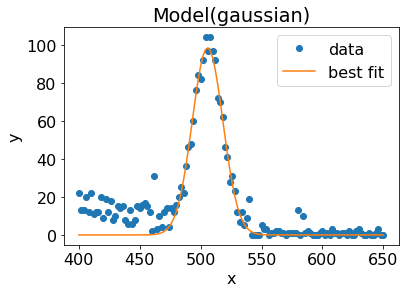

{'amplitude': 3643.916321863474, 'center': 449.156768915333, 'sigma': 100.98163733348393, 'fwhm': 237.79357922563466, 'height': 14.395808949413087}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 126
    # variables        = 3
    chi-square         = 5396.56852
    reduced chi-square = 43.8745408
    Akaike info crit   = 479.411820
    Bayesian info crit = 487.920666
    R-squared          = 0.26873563
[[Variables]]
    amplitude:  3643.91632 +/- 635.195529 (17.43%) (init = 10614)
    center:     449.156769 +/- 19.4353712 (4.33%) (init = 483.5625)
    sigma:      100.981637 +/- 17.9586260 (17.78%) (init = 122)
    fwhm:       237.793579 +/- 42.2893316 (17.78%) == '2.3548200*sigma'
    height:     14.3958089 +/- 0.94913054 (6.59%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.930
    C(amplitude, center) = -0.866
    C(c

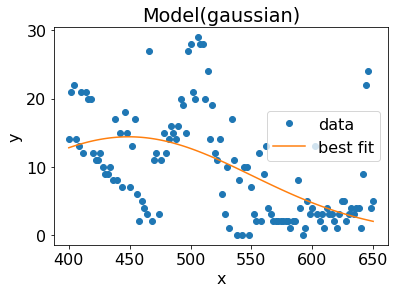

{'amplitude': 602656.9333051243, 'center': 509.4455823564495, 'sigma': 11.284345437051988, 'fwhm': 26.57260232207876, 'height': 21306.095637081413}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 2598397.64
    reduced chi-square = 21125.1841
    Akaike info crit   = 1257.69958
    Bayesian info crit = 1266.20842
    R-squared          = 0.99931580
[[Variables]]
    amplitude:  602656.933 +/- 1592.21501 (0.26%) (init = 768996)
    center:     509.445582 +/- 0.03442528 (0.01%) (init = 510)
    sigma:      11.2843454 +/- 0.03442528 (0.31%) (init = 12)
    fwhm:       26.5726023 +/- 0.08106534 (0.31%) == '2.3548200*sigma'
    height:     21306.0956 +/- 56.2905570 (0.26%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


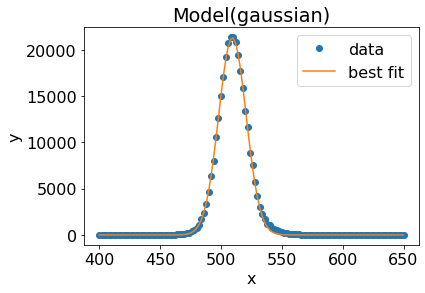

{'amplitude': 615517.5924142151, 'center': 505.1537919097815, 'sigma': 10.991437214135702, 'fwhm': 25.882856180591038, 'height': 22340.66384807153}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 126
    # variables        = 3
    chi-square         = 4901564.56
    reduced chi-square = 39850.1183
    Akaike info crit   = 1337.66667
    Bayesian info crit = 1346.17552
    R-squared          = 0.99880073
[[Variables]]
    amplitude:  615517.592 +/- 2158.26351 (0.35%) (init = 753522)
    center:     505.153792 +/- 0.04450278 (0.01%) (init = 505)
    sigma:      10.9914372 +/- 0.04450278 (0.40%) (init = 11)
    fwhm:       25.8828562 +/- 0.10479605 (0.40%) == '2.3548200*sigma'
    height:     22340.6638 +/- 78.3356815 (0.35%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


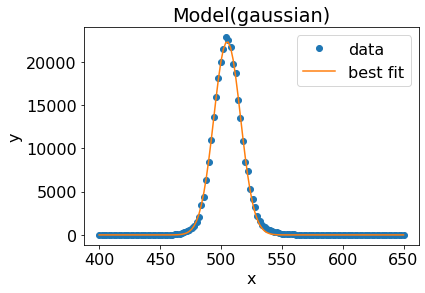

{'amplitude': 488904.97141924524, 'center': 510.42620759880464, 'sigma': 10.988080368409406, 'fwhm': 25.87495141313784, 'height': 17750.586748544316}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 2602936.48
    reduced chi-square = 21162.0852
    Akaike info crit   = 1257.91948
    Bayesian info crit = 1266.42832
    R-squared          = 0.99898977
[[Variables]]
    amplitude:  488904.971 +/- 1572.54608 (0.32%) (init = 608058)
    center:     510.426208 +/- 0.04081034 (0.01%) (init = 511)
    sigma:      10.9880804 +/- 0.04081034 (0.37%) (init = 11)
    fwhm:       25.8749514 +/- 0.09610101 (0.37%) == '2.3548200*sigma'
    height:     17750.5867 +/- 57.0941653 (0.32%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


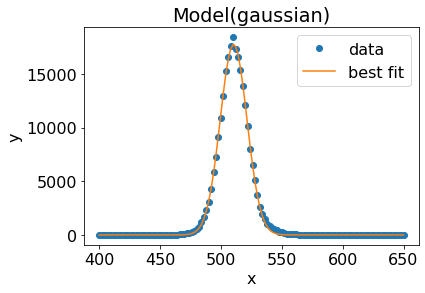

{'amplitude': 644993.7789678584, 'center': 509.9185420503342, 'sigma': 10.96173618906417, 'fwhm': 25.81291561273209, 'height': 23473.95496744724}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 4173847.95
    reduced chi-square = 33933.7231
    Akaike info crit   = 1317.41645
    Bayesian info crit = 1325.92529
    R-squared          = 0.99907347
[[Variables]]
    amplitude:  644993.779 +/- 1988.92672 (0.31%) (init = 853776)
    center:     509.918542 +/- 0.03903123 (0.01%) (init = 510)
    sigma:      10.9617362 +/- 0.03903123 (0.36%) (init = 12)
    fwhm:       25.8129156 +/- 0.09191152 (0.36%) == '2.3548200*sigma'
    height:     23473.9550 +/- 72.3851872 (0.31%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


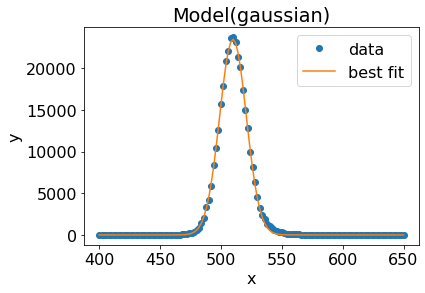

{'amplitude': 567611.1452383526, 'center': 508.5435537395279, 'sigma': 11.170546298165624, 'fwhm': 26.304625833846377, 'height': 20271.53280983295}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 3402851.48
    reduced chi-square = 27665.4592
    Akaike info crit   = 1291.68414
    Bayesian info crit = 1300.19299
    R-squared          = 0.99900244
[[Variables]]
    amplitude:  567611.145 +/- 1812.88167 (0.32%) (init = 752796)
    center:     508.543554 +/- 0.04119671 (0.01%) (init = 508)
    sigma:      11.1705463 +/- 0.04119671 (0.37%) (init = 12)
    fwhm:       26.3046258 +/- 0.09701084 (0.37%) == '2.3548200*sigma'
    height:     20271.5328 +/- 64.7448573 (0.32%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


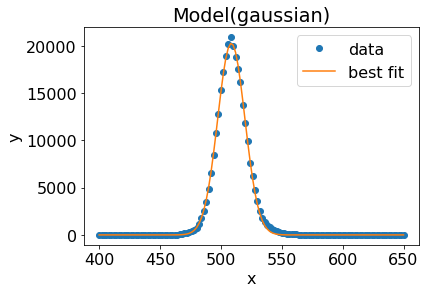

{'amplitude': 534143.1723752781, 'center': 508.97360620774737, 'sigma': 11.321577652657494, 'fwhm': 26.66027748803092, 'height': 18821.7854661511}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 2611089.69
    reduced chi-square = 21228.3714
    Akaike info crit   = 1258.31353
    Bayesian info crit = 1266.82238
    R-squared          = 0.99912153
[[Variables]]
    amplitude:  534143.172 +/- 1598.73028 (0.30%) (init = 696888)
    center:     508.973606 +/- 0.03912858 (0.01%) (init = 510)
    sigma:      11.3215777 +/- 0.03912858 (0.35%) (init = 12)
    fwhm:       26.6602775 +/- 0.09214077 (0.35%) == '2.3548200*sigma'
    height:     18821.7855 +/- 56.3350282 (0.30%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


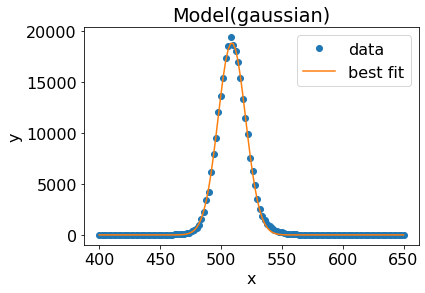

{'amplitude': 4374.71637164584, 'center': 461.2030407455932, 'sigma': 86.9200650562671, 'fwhm': 204.68110759579892, 'height': 20.078901344842123}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 126
    # variables        = 3
    chi-square         = 6757.09256
    reduced chi-square = 54.9357119
    Akaike info crit   = 507.740325
    Bayesian info crit = 516.249171
    R-squared          = 0.38843208
[[Variables]]
    amplitude:  4374.71637 +/- 462.506912 (10.57%) (init = 13104)
    center:     461.203041 +/- 10.1655488 (2.20%) (init = 474.3871)
    sigma:      86.9200651 +/- 10.3595630 (11.92%) (init = 112)
    fwhm:       204.681108 +/- 24.3949061 (11.92%) == '2.3548200*sigma'
    height:     20.0789013 +/- 1.09994152 (5.48%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.888
    C(amplitude, center) = -0.740
    C(cen

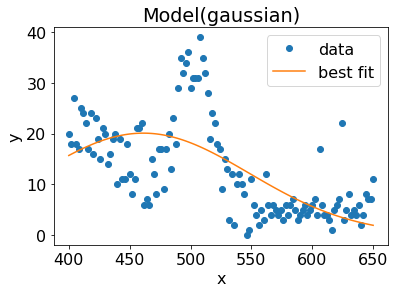

{'amplitude': 533747.138262482, 'center': 514.8800821149929, 'sigma': 11.359546455055003, 'fwhm': 26.749687183292625, 'height': 18744.96590153005}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 4074073.01
    reduced chi-square = 33122.5448
    Akaike info crit   = 1314.36786
    Bayesian info crit = 1322.87670
    R-squared          = 0.99862168
[[Variables]]
    amplitude:  533747.138 +/- 2000.34813 (0.37%) (init = 722826)
    center:     514.880082 +/- 0.04915872 (0.01%) (init = 515)
    sigma:      11.3595465 +/- 0.04915872 (0.43%) (init = 13)
    fwhm:       26.7496872 +/- 0.11575993 (0.43%) == '2.3548200*sigma'
    height:     18744.9659 +/- 70.2513658 (0.37%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


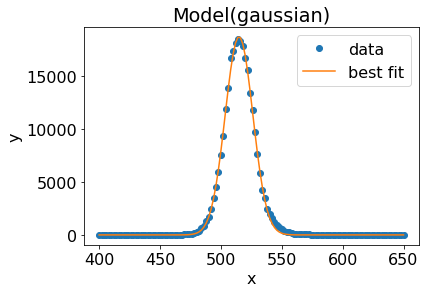

{'amplitude': 458649.65680042777, 'center': 517.3100755064605, 'sigma': 11.384447068241649, 'fwhm': 26.8083236452368, 'height': 16072.343951477842}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 3450295.51
    reduced chi-square = 28051.1830
    Akaike info crit   = 1293.42876
    Bayesian info crit = 1301.93760
    R-squared          = 0.99841422
[[Variables]]
    amplitude:  458649.657 +/- 1842.87128 (0.40%) (init = 573624)
    center:     517.310076 +/- 0.05281966 (0.01%) (init = 518)
    sigma:      11.3844471 +/- 0.05281966 (0.46%) (init = 12)
    fwhm:       26.8083236 +/- 0.12438079 (0.46%) == '2.3548200*sigma'
    height:     16072.3440 +/- 64.5793068 (0.40%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


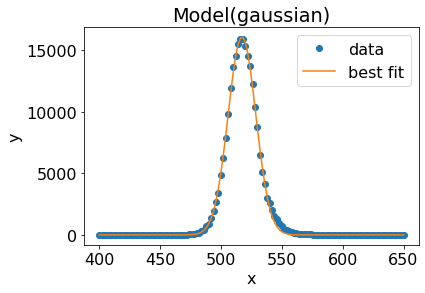

{'amplitude': 515915.58404591354, 'center': 517.4060297232618, 'sigma': 11.254721765560223, 'fwhm': 26.502843907976526, 'height': 18287.484488060552}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 4629203.34
    reduced chi-square = 37635.7995
    Akaike info crit   = 1330.46329
    Bayesian info crit = 1338.97214
    R-squared          = 0.99834064
[[Variables]]
    amplitude:  515915.584 +/- 2122.42100 (0.41%) (init = 658512)
    center:     517.406030 +/- 0.05346351 (0.01%) (init = 518)
    sigma:      11.2547218 +/- 0.05346351 (0.48%) (init = 12)
    fwhm:       26.5028439 +/- 0.12589695 (0.48%) == '2.3548200*sigma'
    height:     18287.4845 +/- 75.2327918 (0.41%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


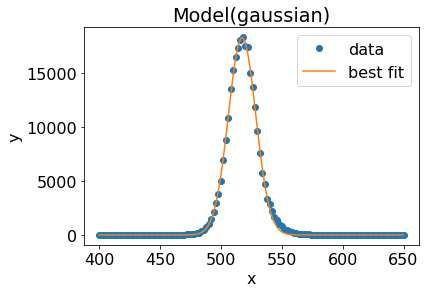

{'amplitude': 243328.6355119491, 'center': 512.6494501015442, 'sigma': 11.115110949309509, 'fwhm': 26.17408556565302, 'height': 8733.52375425718}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 126
    # variables        = 3
    chi-square         = 726241.802
    reduced chi-square = 5904.40490
    Akaike info crit   = 1097.07891
    Bayesian info crit = 1105.58775
    R-squared          = 0.99884405
[[Variables]]
    amplitude:  243328.636 +/- 835.424888 (0.34%) (init = 291159)
    center:     512.649450 +/- 0.04406530 (0.01%) (init = 513)
    sigma:      11.1151109 +/- 0.04406530 (0.40%) (init = 11)
    fwhm:       26.1740856 +/- 0.10376584 (0.40%) == '2.3548200*sigma'
    height:     8733.52375 +/- 29.9849449 (0.34%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


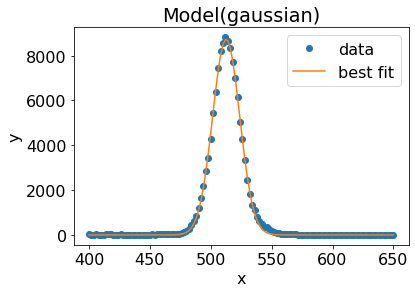

{'amplitude': 447684.376204819, 'center': 506.04065027587535, 'sigma': 10.749532995154029, 'fwhm': 25.31321528764861, 'height': 16614.69710337464}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 2464184.35
    reduced chi-square = 20034.0191
    Akaike info crit   = 1251.01728
    Bayesian info crit = 1259.52612
    R-squared          = 0.99888835
[[Variables]]
    amplitude:  447684.376 +/- 1513.36108 (0.34%) (init = 608976)
    center:     506.040650 +/- 0.04195949 (0.01%) (init = 506)
    sigma:      10.7495330 +/- 0.04195949 (0.39%) (init = 12)
    fwhm:       25.3132153 +/- 0.09880705 (0.39%) == '2.3548200*sigma'
    height:     16614.6971 +/- 56.1647027 (0.34%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


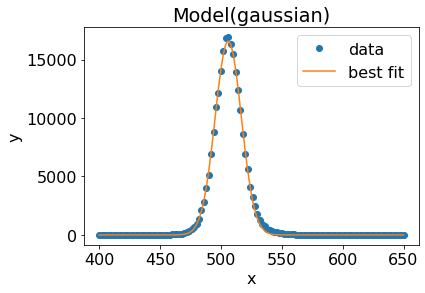

{'amplitude': 4634.999140078595, 'center': 501.68189849580057, 'sigma': 16.076503201465023, 'fwhm': 37.857271268873866, 'height': 115.01862029750798}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 19119.7347
    reduced chi-square = 155.444998
    Akaike info crit   = 638.796495
    Bayesian info crit = 647.305341
    R-squared          = 0.84173371
[[Variables]]
    amplitude:  4634.99914 +/- 163.021149 (3.52%) (init = 6192)
    center:     501.681898 +/- 0.65290791 (0.13%) (init = 502)
    sigma:      16.0765032 +/- 0.65290795 (4.06%) (init = 16)
    fwhm:       37.8572713 +/- 1.53748069 (4.06%) == '2.3548200*sigma'
    height:     115.018620 +/- 4.04538857 (3.52%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


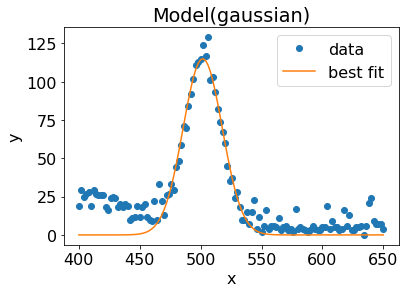

{'amplitude': 433280.3259231134, 'center': 503.2033123574873, 'sigma': 10.64890459482006, 'fwhm': 25.076253517974173, 'height': 16232.07797848031}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 4103696.80
    reduced chi-square = 33363.3886
    Akaike info crit   = 1315.28073
    Bayesian info crit = 1323.78957
    R-squared          = 0.99804453
[[Variables]]
    amplitude:  433280.326 +/- 1943.79763 (0.45%) (init = 547866)
    center:     503.203312 +/- 0.05516413 (0.01%) (init = 503)
    sigma:      10.6489046 +/- 0.05516413 (0.52%) (init = 11)
    fwhm:       25.0762535 +/- 0.12990160 (0.52%) == '2.3548200*sigma'
    height:     16232.0780 +/- 72.8209724 (0.45%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


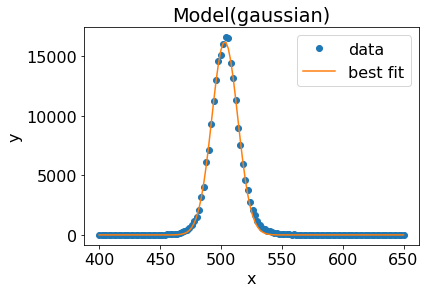

{'amplitude': 30259.715947053053, 'center': 496.5137070049285, 'sigma': 11.10411016906725, 'fwhm': 26.148180708322943, 'height': 1087.1542603109879}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 75325.0689
    reduced chi-square = 612.398934
    Akaike info crit   = 811.554083
    Bayesian info crit = 820.062929
    R-squared          = 0.99209990
[[Variables]]
    amplitude:  30259.7159 +/- 268.920291 (0.89%) (init = 39312)
    center:     496.513707 +/- 0.11394971 (0.02%) (init = 496)
    sigma:      11.1041102 +/- 0.11394971 (1.03%) (init = 12)
    fwhm:       26.1481807 +/- 0.26833106 (1.03%) == '2.3548200*sigma'
    height:     1087.15426 +/- 9.66163910 (0.89%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


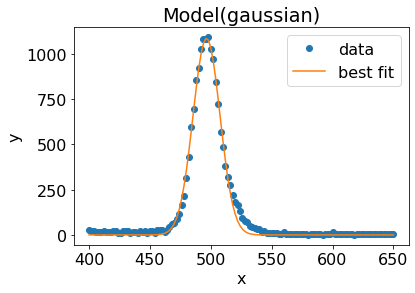

{'amplitude': 65954.0844222223, 'center': 497.2439789685857, 'sigma': 11.109250545133689, 'fwhm': 26.160285368691714, 'height': 2368.4652737732363}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 171645.199
    reduced chi-square = 1395.48942
    Akaike info crit   = 915.329768
    Bayesian info crit = 923.838614
    R-squared          = 0.99626434
[[Variables]]
    amplitude:  65954.0844 +/- 406.038942 (0.62%) (init = 78606)
    center:     497.243979 +/- 0.07897308 (0.02%) (init = 497)
    sigma:      11.1092505 +/- 0.07897308 (0.71%) (init = 11)
    fwhm:       26.1602854 +/- 0.18596739 (0.71%) == '2.3548200*sigma'
    height:     2368.46527 +/- 14.5811682 (0.62%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


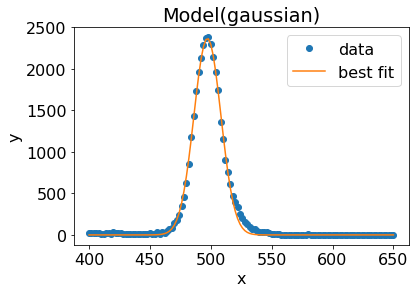

{'amplitude': 54429.663661697145, 'center': 501.91101559753383, 'sigma': 11.56483954388818, 'fwhm': 27.233115454738765, 'height': 1877.6131849489875}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 142764.930
    reduced chi-square = 1160.69049
    Akaike info crit   = 892.116773
    Bayesian info crit = 900.625619
    R-squared          = 0.99521261
[[Variables]]
    amplitude:  54429.6637 +/- 377.825707 (0.69%) (init = 68112)
    center:     501.911016 +/- 0.09269690 (0.02%) (init = 502)
    sigma:      11.5648395 +/- 0.09269690 (0.80%) (init = 12)
    fwhm:       27.2331155 +/- 0.21828452 (0.80%) == '2.3548200*sigma'
    height:     1877.61318 +/- 13.0335356 (0.69%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


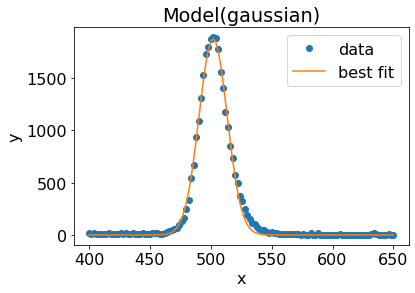

{'amplitude': 436168.358035338, 'center': 513.4890810095219, 'sigma': 10.737116049308392, 'fwhm': 25.28397561523239, 'height': 16206.028429118958}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 2394363.01
    reduced chi-square = 19466.3660
    Akaike info crit   = 1247.39558
    Bayesian info crit = 1255.90443
    R-squared          = 0.99886475
[[Variables]]
    amplitude:  436168.358 +/- 1490.90392 (0.34%) (init = 587448)
    center:     513.489081 +/- 0.04237921 (0.01%) (init = 514)
    sigma:      10.7371160 +/- 0.04237921 (0.39%) (init = 12)
    fwhm:       25.2839756 +/- 0.09979540 (0.39%) == '2.3548200*sigma'
    height:     16206.0284 +/- 55.3952198 (0.34%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


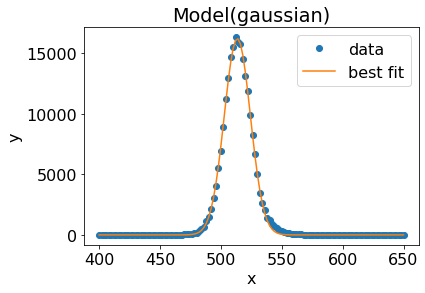

{'amplitude': 9434.710091506815, 'center': 504.39181446702315, 'sigma': 14.417628207607269, 'fwhm': 33.95091925583775, 'height': 261.06269974093004}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 10476.0501
    reduced chi-square = 85.1711391
    Akaike info crit   = 562.991200
    Bayesian info crit = 571.500046
    R-squared          = 0.98373290
[[Variables]]
    amplitude:  9434.71009 +/- 114.275659 (1.21%) (init = 11424)
    center:     504.391814 +/- 0.20164427 (0.04%) (init = 504)
    sigma:      14.4176282 +/- 0.20164428 (1.40%) (init = 14)
    fwhm:       33.9509193 +/- 0.47483598 (1.40%) == '2.3548200*sigma'
    height:     261.062700 +/- 3.16204732 (1.21%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


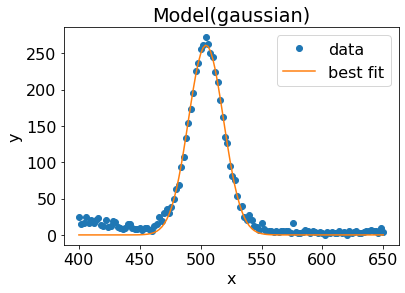

{'amplitude': 413409.9030545672, 'center': 513.4073247788257, 'sigma': 11.213132096054055, 'fwhm': 26.40490772243001, 'height': 14708.352327839288}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1982720.71
    reduced chi-square = 16119.6805
    Akaike info crit   = 1223.62603
    Bayesian info crit = 1232.13488
    R-squared          = 0.99889867
[[Variables]]
    amplitude:  413409.903 +/- 1386.45230 (0.34%) (init = 525096)
    center:     513.407325 +/- 0.04342307 (0.01%) (init = 514)
    sigma:      11.2131321 +/- 0.04342307 (0.39%) (init = 12)
    fwhm:       26.4049077 +/- 0.10225351 (0.39%) == '2.3548200*sigma'
    height:     14708.3523 +/- 49.3273952 (0.34%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


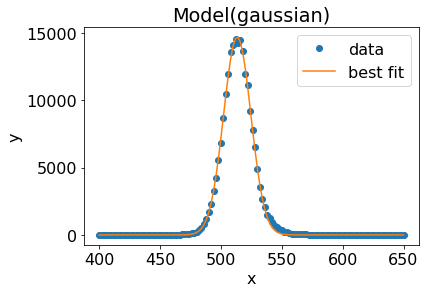

{'amplitude': 353725.8593191508, 'center': 509.293003514106, 'sigma': 11.317851293682093, 'fwhm': 26.651502583388467, 'height': 12468.462804864123}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1344687.64
    reduced chi-square = 10932.4198
    Akaike info crit   = 1174.69919
    Bayesian info crit = 1183.20804
    R-squared          = 0.99896862
[[Variables]]
    amplitude:  353725.859 +/- 1147.10630 (0.32%) (init = 456372)
    center:     509.293004 +/- 0.04238094 (0.01%) (init = 510)
    sigma:      11.3178513 +/- 0.04238094 (0.37%) (init = 12)
    fwhm:       26.6515026 +/- 0.09979950 (0.37%) == '2.3548200*sigma'
    height:     12468.4628 +/- 40.4343112 (0.32%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


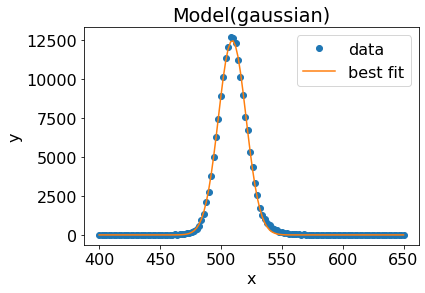

{'amplitude': 210218.37855713404, 'center': 509.6767883510601, 'sigma': 11.40790992165804, 'fwhm': 26.86357444171879, 'height': 7351.478405753812}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 423809.975
    reduced chi-square = 3445.60955
    Akaike info crit   = 1029.21558
    Bayesian info crit = 1037.72442
    R-squared          = 0.99906707
[[Variables]]
    amplitude:  210218.379 +/- 646.546128 (0.31%) (init = 270396)
    center:     509.676788 +/- 0.04051395 (0.01%) (init = 510)
    sigma:      11.4079099 +/- 0.04051395 (0.36%) (init = 12)
    fwhm:       26.8635744 +/- 0.09540307 (0.36%) == '2.3548200*sigma'
    height:     7351.47841 +/- 22.6101661 (0.31%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


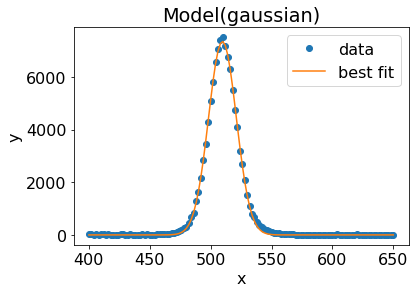

{'amplitude': 412825.40084181447, 'center': 505.51890314350493, 'sigma': 10.900050625945688, 'fwhm': 25.66765721498943, 'height': 15109.426603783926}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 2590667.64
    reduced chi-square = 21062.3386
    Akaike info crit   = 1257.32418
    Bayesian info crit = 1265.83302
    R-squared          = 0.99860471
[[Variables]]
    amplitude:  412825.401 +/- 1562.53762 (0.38%) (init = 509223)
    center:     505.518903 +/- 0.04763891 (0.01%) (init = 505)
    sigma:      10.9000506 +/- 0.04763891 (0.44%) (init = 11)
    fwhm:       25.6676572 +/- 0.11218105 (0.44%) == '2.3548200*sigma'
    height:     15109.4266 +/- 57.1889268 (0.38%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


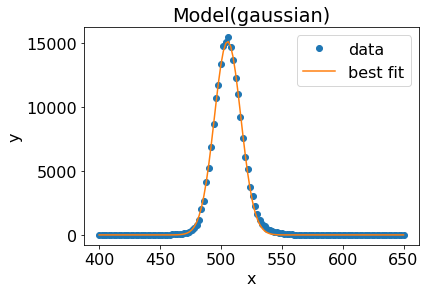

{'amplitude': 297163.9809653674, 'center': 504.84400005644994, 'sigma': 10.688875676413822, 'fwhm': 25.170378220332797, 'height': 11091.08999228762}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1318927.75
    reduced chi-square = 10722.9898
    Akaike info crit   = 1172.26202
    Bayesian info crit = 1180.77086
    R-squared          = 0.99866015
[[Variables]]
    amplitude:  297163.981 +/- 1104.04671 (0.37%) (init = 368808)
    center:     504.844000 +/- 0.04585567 (0.01%) (init = 505)
    sigma:      10.6888757 +/- 0.04585567 (0.43%) (init = 11)
    fwhm:       25.1703782 +/- 0.10798185 (0.43%) == '2.3548200*sigma'
    height:     11091.0900 +/- 41.2065035 (0.37%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


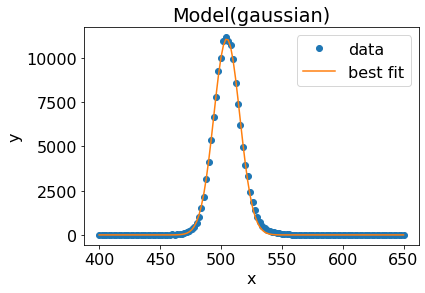

{'amplitude': 275010.29793074046, 'center': 501.64512279847827, 'sigma': 11.812477795065057, 'fwhm': 27.816258961375098, 'height': 9287.910858635447}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 946930.103
    reduced chi-square = 7698.61873
    Akaike info crit   = 1130.51203
    Bayesian info crit = 1139.02088
    R-squared          = 0.99873270
[[Variables]]
    amplitude:  275010.298 +/- 983.423840 (0.36%) (init = 369213)
    center:     501.645123 +/- 0.04877563 (0.01%) (init = 501)
    sigma:      11.8124778 +/- 0.04877563 (0.41%) (init = 13)
    fwhm:       27.8162590 +/- 0.11485783 (0.41%) == '2.3548200*sigma'
    height:     9287.91086 +/- 33.2131682 (0.36%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


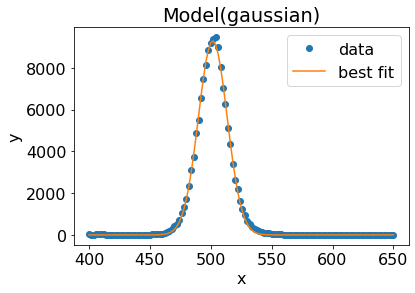

{'amplitude': 296791.26810359175, 'center': 499.73455994124987, 'sigma': 14.34512547238057, 'fwhm': 33.780188364871215, 'height': 8253.855384195162}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 713960.217
    reduced chi-square = 5804.55461
    Akaike info crit   = 1094.92988
    Bayesian info crit = 1103.43872
    R-squared          = 0.99896668
[[Variables]]
    amplitude:  296791.268 +/- 941.021533 (0.32%) (init = 387456)
    center:     499.734560 +/- 0.05251967 (0.01%) (init = 500)
    sigma:      14.3451255 +/- 0.05251967 (0.37%) (init = 16)
    fwhm:       33.7801884 +/- 0.12367438 (0.37%) == '2.3548200*sigma'
    height:     8253.85538 +/- 26.1700888 (0.32%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


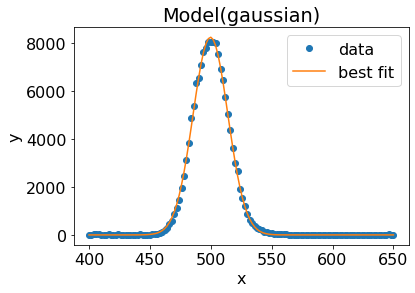

{'amplitude': 242292.3951915264, 'center': 509.8940538428096, 'sigma': 12.498600960193254, 'fwhm': 29.431955513082283, 'height': 7733.720415434553}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 126
    # variables        = 3
    chi-square         = 4857392.26
    reduced chi-square = 39490.9940
    Akaike info crit   = 1336.52603
    Bayesian info crit = 1345.03487
    R-squared          = 0.99098010
[[Variables]]
    amplitude:  242292.395 +/- 2291.09025 (0.95%) (init = 288288)
    center:     509.894054 +/- 0.13646854 (0.03%) (init = 510)
    sigma:      12.4986010 +/- 0.13646854 (1.09%) (init = 12)
    fwhm:       29.4319555 +/- 0.32135885 (1.09%) == '2.3548200*sigma'
    height:     7733.72042 +/- 73.1291388 (0.95%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


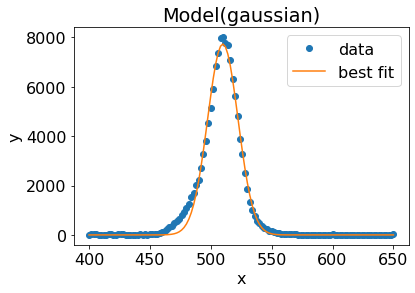

{'amplitude': 347962.24020824337, 'center': 495.5985483658876, 'sigma': 13.426727006539167, 'fwhm': 31.617525289538563, 'height': 10338.845524618297}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 1106610.30
    reduced chi-square = 8996.83170
    Akaike info crit   = 1150.14681
    Bayesian info crit = 1158.65565
    R-squared          = 0.99892177
[[Variables]]
    amplitude:  347962.240 +/- 1133.42563 (0.33%) (init = 462555)
    center:     495.598548 +/- 0.05050106 (0.01%) (init = 495)
    sigma:      13.4267270 +/- 0.05050106 (0.38%) (init = 15)
    fwhm:       31.6175253 +/- 0.11892091 (0.38%) == '2.3548200*sigma'
    height:     10338.8455 +/- 33.6769694 (0.33%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


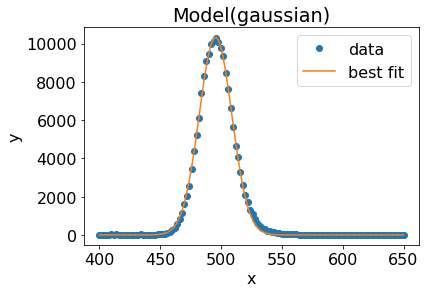

{'amplitude': 359290.5627764818, 'center': 507.32248610095803, 'sigma': 13.370968333804974, 'fwhm': 31.486223651810633, 'height': 10719.956842613723}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 126
    # variables        = 3
    chi-square         = 5453024.67
    reduced chi-square = 44333.5339
    Akaike info crit   = 1351.10029
    Bayesian info crit = 1359.60913
    R-squared          = 0.99504259
[[Variables]]
    amplitude:  359290.563 +/- 2510.79966 (0.70%) (init = 465234)
    center:     507.322486 +/- 0.10789463 (0.02%) (init = 508)
    sigma:      13.3709683 +/- 0.10789463 (0.81%) (init = 14)
    fwhm:       31.4862237 +/- 0.25407244 (0.81%) == '2.3548200*sigma'
    height:     10719.9568 +/- 74.9135184 (0.70%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


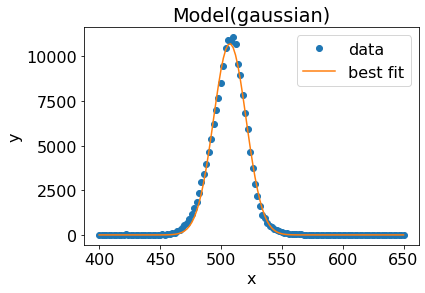

{'amplitude': 258681.2143806132, 'center': 510.39506743310227, 'sigma': 12.180075042638382, 'fwhm': 28.681884311905716, 'height': 8472.762135744651}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 126
    # variables        = 3
    chi-square         = 1464461.68
    reduced chi-square = 11906.1925
    Akaike info crit   = 1185.45026
    Bayesian info crit = 1193.95911
    R-squared          = 0.99769557
[[Variables]]
    amplitude:  258681.214 +/- 1241.86588 (0.48%) (init = 336531)
    center:     510.395067 +/- 0.06751951 (0.01%) (init = 511)
    sigma:      12.1800750 +/- 0.06751951 (0.55%) (init = 13)
    fwhm:       28.6818843 +/- 0.15899630 (0.55%) == '2.3548200*sigma'
    height:     8472.76214 +/- 40.6756890 (0.48%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


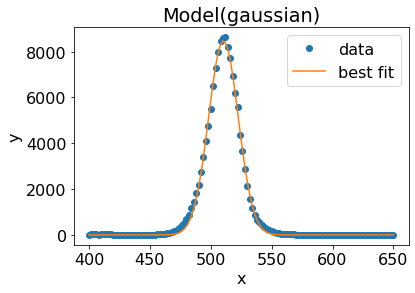

In [ ]:

data = Readfinal
result_readfinal= np.zeros((data.shape[0],data.shape[1],4))
x = luminescence_wavelength  #np.arange(dat.shape[0])


 
fwhm2=[]
center2=[]
height2=[]
fit_data=[]
for i in range (40):
  y=data[:,i]
  mod = GaussianModel()
  pars = mod.guess(y, x=x)
  result = mod.fit(y, pars, x=x) 
  val= result.params.valuesdict()
  f= np.array(val['fwhm'])
  fwhm2.append(f)
  c= np.array(val['center'])
  center2.append(c)
  h=np.array(val['height'])
  height2.append(h)

  print(result.params.valuesdict())
  para=result.fit_report()
  print(result.fit_report())
  
  result.plot_fit()
      
      
  plt.show()
  
  



##Intensity Bar Plot for Final Read

In [ ]:
intensity_bar2= pd.DataFrame(height2)
intensity_bar2.rename(columns={intensity_bar2.columns[0]: 'Height'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

intensity_bar2['wells']=wells

print(intensity_bar2)

          Height  wells
0     521.701508  1:0.1
1     791.815345  1:0.2
2     107.951691  1:0.3
3     316.375344  1:0.4
4     747.096728  1:0.5
5      52.252055  1:0.6
6     148.888676  1:0.7
7      14.756357  1:0.8
8      98.470554  1:0.9
9      14.395809    1:1
10  21306.095637  1:1.1
11  22340.663848  1:1.2
12  17750.586749  1:1.3
13  23473.954967  1:1.4
14  20271.532810  1:1.5
15  18821.785466  1:1.6
16     20.078901  1:1.7
17  18744.965902  1:1.8
18  16072.343951  1:1.9
19  18287.484488    1:2
20   8733.523754  1:0.1
21  16614.697103  1:0.2
22    115.018620  1:0.3
23  16232.077978  1:0.4
24   1087.154260  1:0.5
25   2368.465274  1:0.6
26   1877.613185  1:0.7
27  16206.028429  1:0.8
28    261.062700  1:0.9
29  14708.352328    1:1
30  12468.462805  1:1.1
31   7351.478406  1:1.2
32  15109.426604  1:1.3
33  11091.089992  1:1.4
34   9287.910859  1:1.5
35   8253.855384  1:1.6
36   7733.720415  1:1.7
37  10338.845525  1:1.8
38  10719.956843  1:1.9
39   8472.762136    1:2


Text(0.5, 1.0, '150 ul PbBr2')

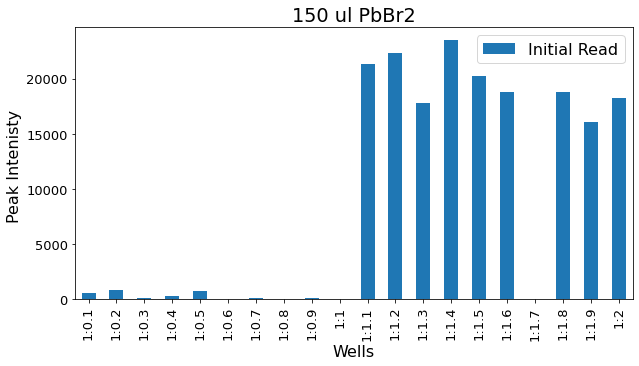

In [ ]:

plotdata= intensity_bar2[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(10,5),cmap=cmap);


ax.set_xlabel("Wells")
ax.set_ylabel("Peak Intenisty ")
ax.set_xticklabels(intensity_bar2['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'])

ax.set_title('150 ul PbBr2')

## FWHM Bar Plot for Final Read

In [ ]:
fwhm_bar2= pd.DataFrame(fwhm2)
fwhm_bar2.rename(columns={fwhm_bar2.columns[0]: 'fwhm'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

fwhm_bar2['wells']=wells

print(fwhm_bar2)

          fwhm  wells
0    31.734722  1:0.1
1    27.704420  1:0.2
2    29.494317  1:0.3
3    26.084456  1:0.4
4    25.974687  1:0.5
5    32.913539  1:0.6
6    29.090786  1:0.7
7   218.878537  1:0.8
8    29.707859  1:0.9
9   237.793579    1:1
10   26.572602  1:1.1
11   25.882856  1:1.2
12   25.874951  1:1.3
13   25.812916  1:1.4
14   26.304626  1:1.5
15   26.660277  1:1.6
16  204.681108  1:1.7
17   26.749687  1:1.8
18   26.808324  1:1.9
19   26.502844    1:2
20   26.174086  1:0.1
21   25.313215  1:0.2
22   37.857271  1:0.3
23   25.076254  1:0.4
24   26.148181  1:0.5
25   26.160285  1:0.6
26   27.233115  1:0.7
27   25.283976  1:0.8
28   33.950919  1:0.9
29   26.404908    1:1
30   26.651503  1:1.1
31   26.863574  1:1.2
32   25.667657  1:1.3
33   25.170378  1:1.4
34   27.816259  1:1.5
35   33.780188  1:1.6
36   29.431956  1:1.7
37   31.617525  1:1.8
38   31.486224  1:1.9
39   28.681884    1:2


Text(0.5, 1.0, '300 ul PbBr2')

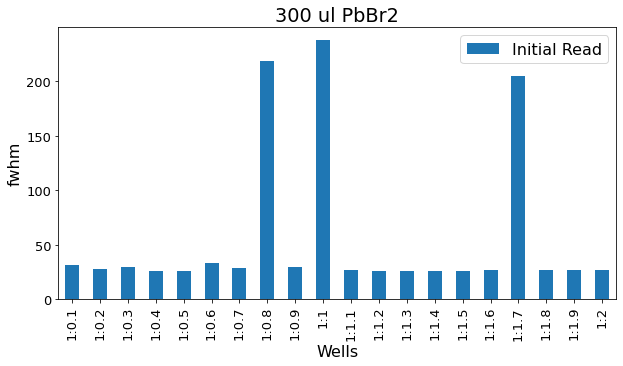

In [ ]:

plotdata= fwhm_bar2[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(10,5),cmap=cmap);


ax.set_xlabel("Wells")
ax.set_ylabel("fwhm")
ax.set_xticklabels(fwhm_bar2['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'])

ax.set_title('300 ul PbBr2')

##Position Bar Plot for Final Read

In [ ]:
center_bar2= pd.DataFrame(center2)
center_bar2.rename(columns={center_bar2.columns[0]: 'center'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

center_bar2['wells']=wells

print(center_bar2)

        center  wells
0   514.877548  1:0.1
1   506.274868  1:0.2
2   509.841953  1:0.3
3   506.581765  1:0.4
4   505.912391  1:0.5
5   509.911292  1:0.6
6   507.855937  1:0.7
7   420.372662  1:0.8
8   505.680595  1:0.9
9   449.156769    1:1
10  509.445582  1:1.1
11  505.153792  1:1.2
12  510.426208  1:1.3
13  509.918542  1:1.4
14  508.543554  1:1.5
15  508.973606  1:1.6
16  461.203041  1:1.7
17  514.880082  1:1.8
18  517.310076  1:1.9
19  517.406030    1:2
20  512.649450  1:0.1
21  506.040650  1:0.2
22  501.681898  1:0.3
23  503.203312  1:0.4
24  496.513707  1:0.5
25  497.243979  1:0.6
26  501.911016  1:0.7
27  513.489081  1:0.8
28  504.391814  1:0.9
29  513.407325    1:1
30  509.293004  1:1.1
31  509.676788  1:1.2
32  505.518903  1:1.3
33  504.844000  1:1.4
34  501.645123  1:1.5
35  499.734560  1:1.6
36  509.894054  1:1.7
37  495.598548  1:1.8
38  507.322486  1:1.9
39  510.395067    1:2


Text(0.5, 1.0, '300 ul PbBr2')

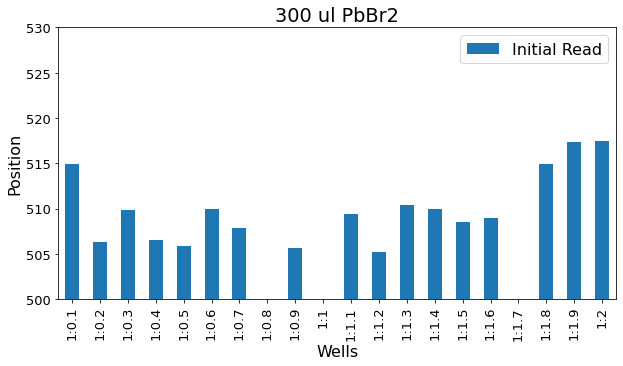

In [ ]:

plotdata= center_bar2[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(10,5),cmap=cmap);

plt.ylim([500, 530])
ax.set_xlabel("Wells")
ax.set_ylabel("Position")
ax.set_xticklabels(center_bar2['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'])

ax.set_title('300 ul PbBr2')

##Combined Intial and Final Read

###Combined Intensity Bar Plot

In [ ]:
final_height= np.vstack((height,height2)).T

height_final=pd.DataFrame(final_height)

In [ ]:
height_final

,0,1
0,12896.540468,521.701508
1,9766.472104,791.815345
2,7610.642671,107.951691
3,10619.244119,316.375344
4,9882.867353,747.096728
5,12562.068398,52.252055
6,12115.034624,148.888676
7,12543.513828,14.756357
8,12730.086465,98.470554
9,13179.563203,14.395809


In [ ]:

height_final.rename(columns={height_final.columns[0]: 'Initial Height', height_final.columns[1]:'Final Height'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

height_final['wells']=wells

print(height_final)

    Initial Height  Final Height  wells
0     12896.540468    521.701508  1:0.1
1      9766.472104    791.815345  1:0.2
2      7610.642671    107.951691  1:0.3
3     10619.244119    316.375344  1:0.4
4      9882.867353    747.096728  1:0.5
5     12562.068398     52.252055  1:0.6
6     12115.034624    148.888676  1:0.7
7     12543.513828     14.756357  1:0.8
8     12730.086465     98.470554  1:0.9
9     13179.563203     14.395809    1:1
10    13525.792372  21306.095637  1:1.1
11    10443.729189  22340.663848  1:1.2
12    11207.791147  17750.586749  1:1.3
13    12001.354515  23473.954967  1:1.4
14    13311.323702  20271.532810  1:1.5
15    12401.427664  18821.785466  1:1.6
16    11083.179399     20.078901  1:1.7
17    12649.597042  18744.965902  1:1.8
18    10071.222065  16072.343951  1:1.9
19    12912.820926  18287.484488    1:2
20     8157.438237   8733.523754  1:0.1
21     9624.905141  16614.697103  1:0.2
22       46.731051    115.018620  1:0.3
23     9446.572599  16232.077978  1:0.4


\

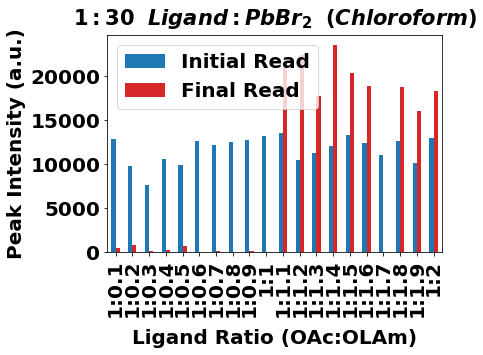

In [ ]:

plt.rcParams['font.sans-serif'] = 'Calibri'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.size"] = "20"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plotdata= height_final[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(6,4),cmap=cmap);


ax.set_xlabel("Ligand Ratio (OAc:OLAm)", labelpad=12, size=20)
ax.set_ylabel("Peak Intensity (a.u.)", size=20)
ax.set_xticklabels(height_final['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'])

ax.set_title('$1:30$  $Ligand:PbBr_2$  $(Chloroform)$',size=21,pad=10)

plt.savefig('Peak intensity OA OLA Chloroform.tif', bbox_inches='tight',dpi=300)

###Combined FWHM Bar Plot

In [ ]:
final_fwhm= np.vstack((fwhm,fwhm2)).T

fwhm_final=pd.DataFrame(final_fwhm)


fwhm_final.rename(columns={fwhm_final.columns[0]: 'Initial FWHM', fwhm_final.columns[1]:'Final FWHM'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

fwhm_final['wells']=wells

print(fwhm_final)

    Initial FWHM  Final FWHM  wells
0      31.896584   31.734722  1:0.1
1      36.325975   27.704420  1:0.2
2      32.935334   29.494317  1:0.3
3      32.112503   26.084456  1:0.4
4      29.789163   25.974687  1:0.5
5      33.484985   32.913539  1:0.6
6      32.447130   29.090786  1:0.7
7      34.161495  218.878537  1:0.8
8      33.404785   29.707859  1:0.9
9      33.440180  237.793579    1:1
10     32.599164   26.572602  1:1.1
11     28.430962   25.882856  1:1.2
12     37.530857   25.874951  1:1.3
13     34.355935   25.812916  1:1.4
14     34.089211   26.304626  1:1.5
15     34.021221   26.660277  1:1.6
16     44.058496  204.681108  1:1.7
17     41.725061   26.749687  1:1.8
18     42.164455   26.808324  1:1.9
19     43.694239   26.502844    1:2
20     29.044344   26.174086  1:0.1
21     27.679313   25.313215  1:0.2
22     38.881278   37.857271  1:0.3
23     27.804762   25.076254  1:0.4
24     26.331700   26.148181  1:0.5
25     26.269836   26.160285  1:0.6
26     26.268352   27.233115

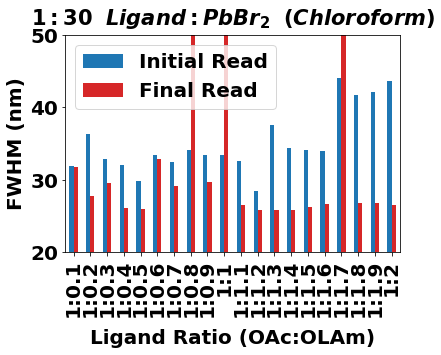

In [ ]:

plt.rcParams['font.sans-serif'] = 'Calibri'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.size"] = "20"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plotdata= fwhm_final[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(6,4),cmap=cmap);

plt.ylim([20, 50])
ax.set_xlabel("Ligand Ratio (OAc:OLAm)", labelpad=12, size=20)
ax.set_ylabel("FWHM (nm)", size=20)
ax.set_xticklabels(fwhm_final['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'])

ax.set_title('$1:30$  $Ligand:PbBr_2$  $(Chloroform)$',size=21,pad=10)


plt.savefig('FWHM Chloroform.tif', bbox_inches='tight',dpi=300)

###Combined Peak Position Bar Plot

In [ ]:
final_center= np.vstack((center,center2)).T

center_final=pd.DataFrame(final_center)


center_final.rename(columns={center_final.columns[0]: 'Initial center', center_final.columns[1]:'Final center'},inplace=True)

compositions = list(composition.iloc[3,0:40])
wells= compositions

center_final['wells']=wells

print(center_final)

    Initial center  Final center  wells
0       504.590614    514.877548  1:0.1
1       504.578054    506.274868  1:0.2
2       508.486708    509.841953  1:0.3
3       509.250743    506.581765  1:0.4
4       510.634253    505.912391  1:0.5
5       506.849086    509.911292  1:0.6
6       508.101192    507.855937  1:0.7
7       506.714525    420.372662  1:0.8
8       503.445762    505.680595  1:0.9
9       505.458035    449.156769    1:1
10      491.234510    509.445582  1:1.1
11      490.431168    505.153792  1:1.2
12      489.276653    510.426208  1:1.3
13      490.999465    509.918542  1:1.4
14      488.928088    508.543554  1:1.5
15      489.223353    508.973606  1:1.6
16      489.902123    461.203041  1:1.7
17      490.691415    514.880082  1:1.8
18      499.860222    517.310076  1:1.9
19      490.761987    517.406030    1:2
20      503.867888    512.649450  1:0.1
21      498.743591    506.040650  1:0.2
22      496.976056    501.681898  1:0.3
23      492.858950    503.203312  1:0.4


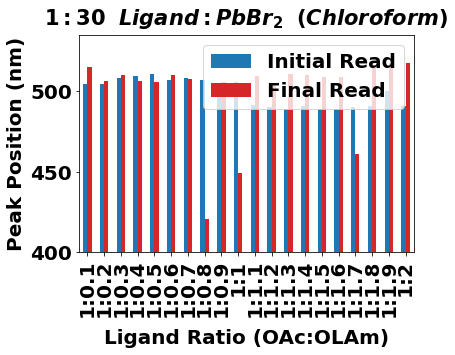

In [ ]:

plt.rcParams['font.sans-serif'] = 'Calibri'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.size"] = "20"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plotdata= center_final[0:20]
cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("tab10").colors[:4])
ax = plotdata.plot(kind='bar', figsize=(6,4),cmap=cmap);

plt.ylim([400, 535])
ax.set_xlabel("Ligand Ratio (OAc:OLAm)", labelpad=12, size=20)
ax.set_ylabel("Peak Position (nm)", size=20)
ax.set_xticklabels(center_final['wells'].iloc[0:20])
ax.legend(['Initial Read','Final Read'])

ax.set_title('$1:30$  $Ligand:PbBr_2$  $(Chloroform)$',size=21,pad=10)

plt.savefig('Peak Position Chloroform.tif', bbox_inches='tight',dpi=300)